<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-and-Data-Loading" data-toc-modified-id="Imports-and-Data-Loading-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports and Data Loading</a></span></li><li><span><a href="#Statistical-Diagnostic-and-Tests.-Sector-Composites" data-toc-modified-id="Statistical-Diagnostic-and-Tests.-Sector-Composites-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Statistical Diagnostic and Tests. Sector Composites</a></span></li><li><span><a href="#Hyperparameter-tuning---for-1-random-composite" data-toc-modified-id="Hyperparameter-tuning---for-1-random-composite-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Hyperparameter tuning - for 1 random composite</a></span></li><li><span><a href="#Statistical-Diagnostic-of-Normalized-Prices" data-toc-modified-id="Statistical-Diagnostic-of-Normalized-Prices-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Statistical Diagnostic of Normalized Prices</a></span></li><li><span><a href="#Hyperparameter-tuning" data-toc-modified-id="Hyperparameter-tuning-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Hyperparameter tuning</a></span></li><li><span><a href="#Collecting-all-models-and-validation-results" data-toc-modified-id="Collecting-all-models-and-validation-results-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Collecting all models and validation results</a></span></li></ul></div>

**DESCRIPTION and KEY NOTES**
- Tuning and fitting predictor models with SARIMAX algorithm from `statsmodels` library is realized in this notebook
- Important point here is to define which unit is used in time series: NetPriceMargin or Absolute Price (normalized to first basis date)
- This point linked to the fact, that almost all NetPriceMargin series has symmetrical KDE around 0 and seems like White Noise process which creates some risk of its modelling results.
- On the first step I will try to create models based on NetPriceMargin for randomly selected 1 example (from sector composites)
- Next, same operation will be done for Normalized Prices.
- Based on comparison above, time series will be used for chosen unit


**Statistical tests and main metric**
- Time Series visual analysis with rolling window - for cycles and trend identification
- ADF-test on stationarity
- ACF and PACF plots - for understanding hyperparameter possible space
- In order to keep ML principle to train model on TRAIN DATASET and calculate metric on TEST DATASET, I will split timeline for series into train part (for hyperparameter search) covering first 80% of the whole timeline, and test part (latest 20% of timeline)
- Base metric: R2-score
  - 1-step-ahead forecast (on test timeline)
  - full forecast (on test timeline)


**Limitations of models**
- this models use 1-D shape of inputs and do not take to account financial statements


**Functions**
- `rolling_plots` - create and show rolling plots with original time serie, rolling average time series and std


- `show_acf_pacf` - create and show ACF and PACF plots for given time serie


- `show_adf_test` - calculate and show ADF test for given time serie


- `find_optimal_params` - create grid search loops for given ts with initialization of SARIMAX models for each iteration and return pd.Series for optimal params


- `run_arima_model` - create and fit SARIMAX model with given data, plot forecast results and r2_score


- `calculate_r2_on_period` - calculate r2 scores based on given model, time series and period for forecasting


**Commented code and checkpoints**
- because finding optimal params can take a lot of time, I used here checkpoint saves and loads
- commented parts of the code (param search) can be ignored in this code
- in last part (part 6) already tuned hyperparams loaded in DICT form as checkpoint

#### Imports and Data Loading

In [1]:
# 1.1. Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import itertools
import statsmodels.api as sm
import operator
import csv
import time
import warnings
import pickle
from datetime import date as dt
from datetime import timedelta
from matplotlib.pylab import rcParams
from sklearn.metrics import r2_score, f1_score, accuracy_score
import seaborn as sns

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
# 1.2. Functions from project_lib
from project_lib import rolling_plots, show_acf_pacf
from project_lib import show_adf_test, find_optimal_params
from project_lib import run_arima_model, calculate_r2_on_period

In [3]:
# 1.3. Data Loading
with open('datasets_4_modelling/cluster_composites.csv', 'r', encoding='utf-8') as f:
    cluster_composite = pd.read_csv(f)
    cluster_composite = cluster_composite.set_index(pd.to_datetime(cluster_composite.date, format='%Y-%m-%d'))
    cluster_composite = cluster_composite.drop(columns=['date'], axis=1)
    
with open('datasets_4_modelling/sector_composites.csv', 'r', encoding='utf-8') as f:
    sector_composite = pd.read_csv(f)
    sector_composite = sector_composite.set_index(pd.to_datetime(sector_composite.date, format='%Y-%m-%d'))
    sector_composite = sector_composite.drop(columns=['date'], axis=1)
    
with open('datasets_4_modelling/cluster_test_comps.pkl', 'rb') as f: 
    cluster_test_comps = pickle.load(f)
    
with open('datasets_4_modelling/sector_test_comps.pkl', 'rb') as f:
    sector_test_comps = pickle.load(f)
    
with open('datasets/df_prices_cleaned.csv', 'r', encoding='utf-8') as f:
    df_prices = pd.read_csv(f)
    df_prices = df_prices.set_index(pd.to_datetime(df_prices.date, format='%Y-%m-%d'))
    df_prices = df_prices.drop(columns=['date'], axis=1)

In [4]:
# 1.4. stock prices normalization
first_price_row = df_prices.iloc[0]
df_prices_norm = df_prices.copy()
for col, first_price in zip(df_prices.columns, first_price_row):
    norm_prices = df_prices[col]/first_price
    df_prices_norm[col] = norm_prices

#### Statistical Diagnostic and Tests. Sector Composites

7 days delta analysis
----------------------------------------------------------------------------------------------------
Basic Materials
--------------------------------------------------------------------------------


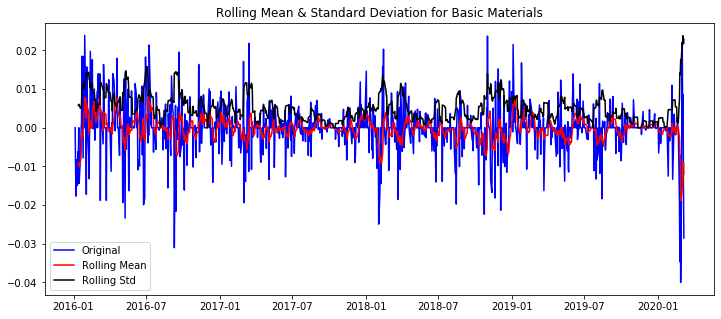

Communication Services
--------------------------------------------------------------------------------


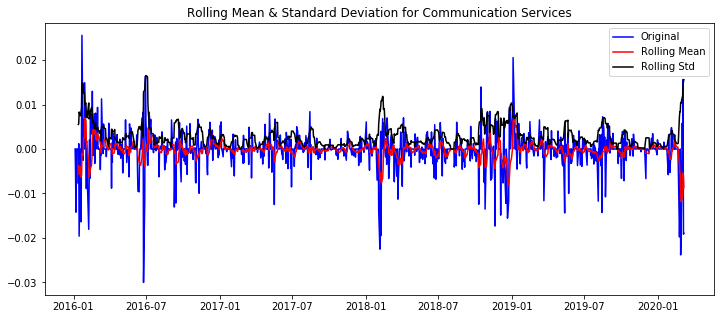

Consumer Cyclical
--------------------------------------------------------------------------------


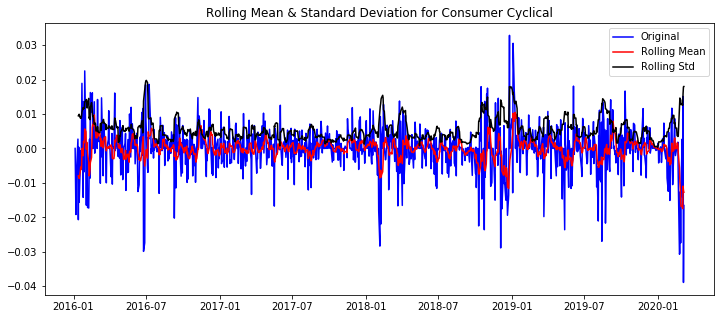

Consumer Defensive
--------------------------------------------------------------------------------


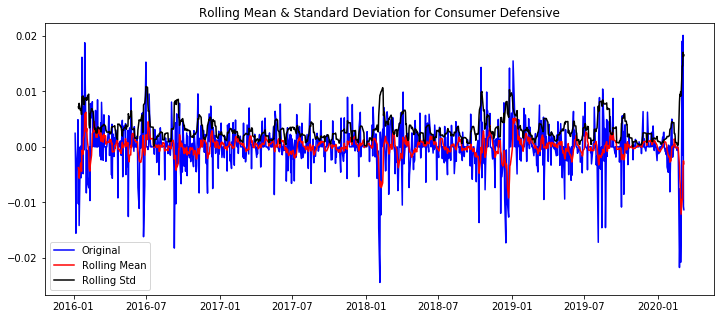

Diversified
--------------------------------------------------------------------------------


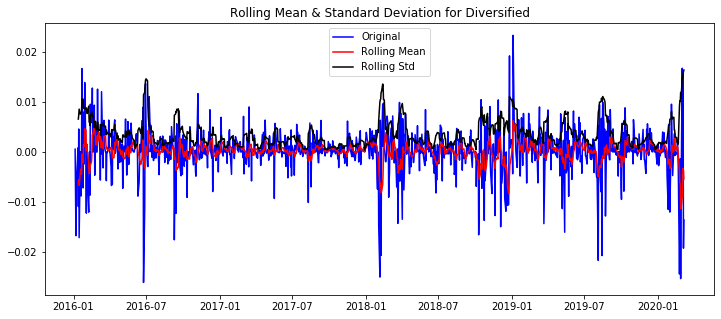

Energy
--------------------------------------------------------------------------------


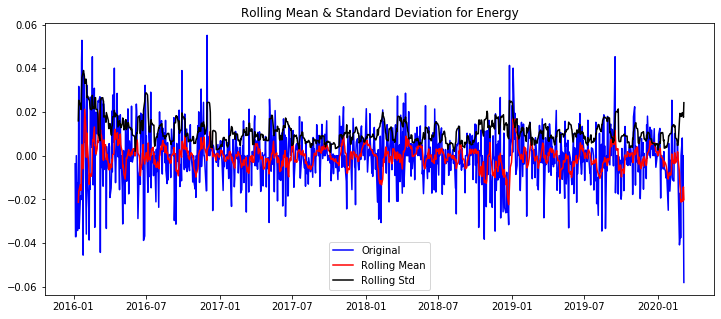

Financial
--------------------------------------------------------------------------------


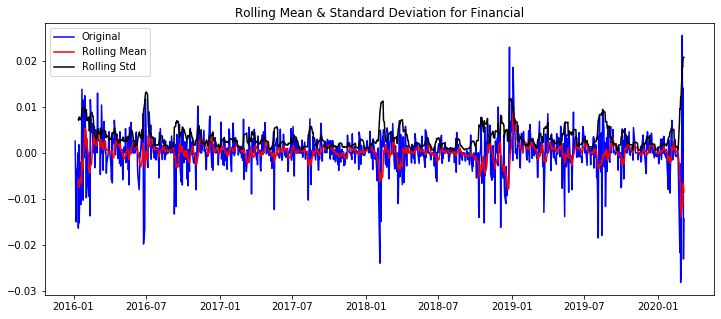

Healthcare
--------------------------------------------------------------------------------


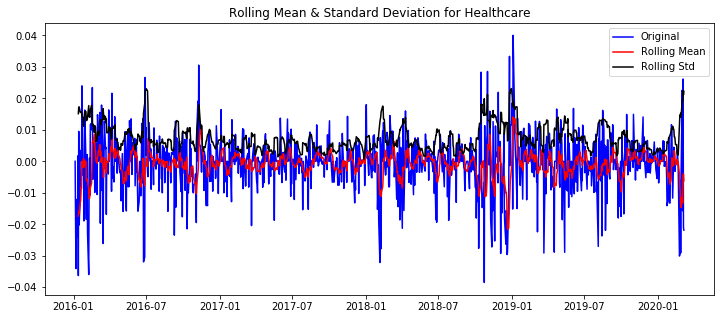

Industrials
--------------------------------------------------------------------------------


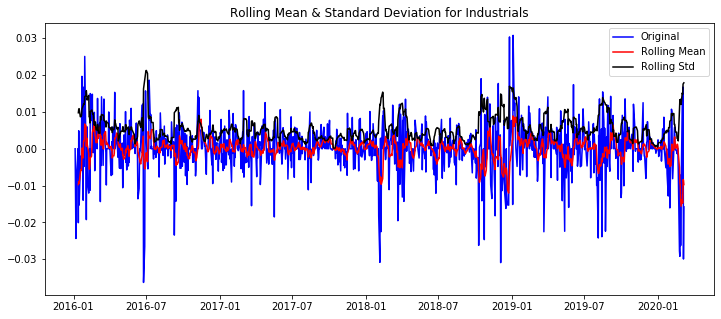

Real Estate
--------------------------------------------------------------------------------


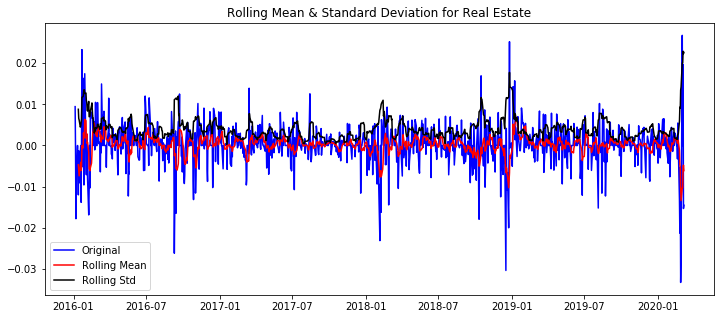

Technology
--------------------------------------------------------------------------------


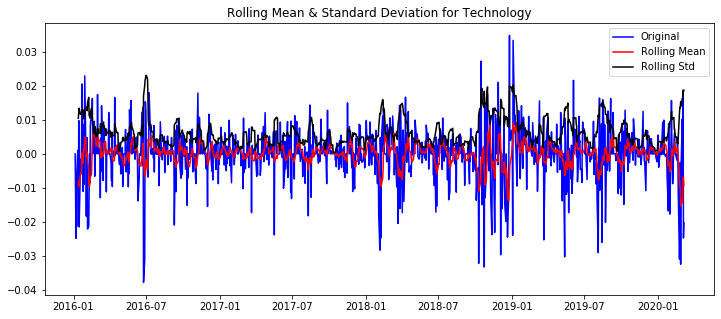

Utilities
--------------------------------------------------------------------------------


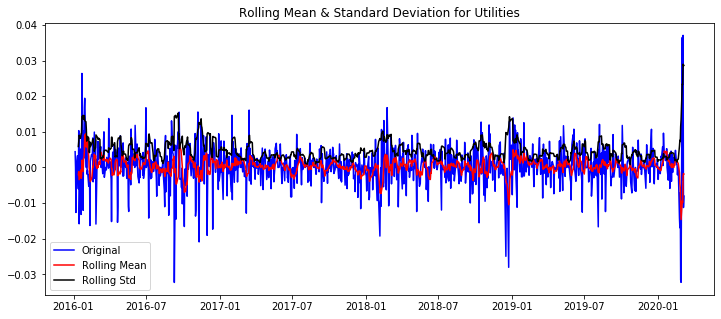

In [5]:
# 2.1. Visual Analysis - 1 week delta

window = 7
print('7 days delta analysis')
print(100*'-')
for col in sector_composite.columns:
    rolling_plots(sector_composite, col, window=window, figsize=(10,4))

Any mid-term or long term trends not identified here

30 days delta analysis
----------------------------------------------------------------------------------------------------
Basic Materials
--------------------------------------------------------------------------------


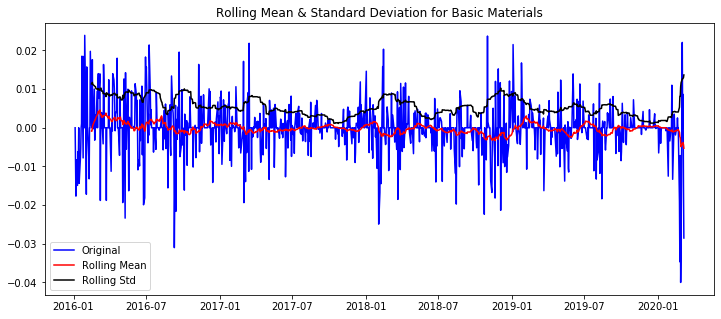

Communication Services
--------------------------------------------------------------------------------


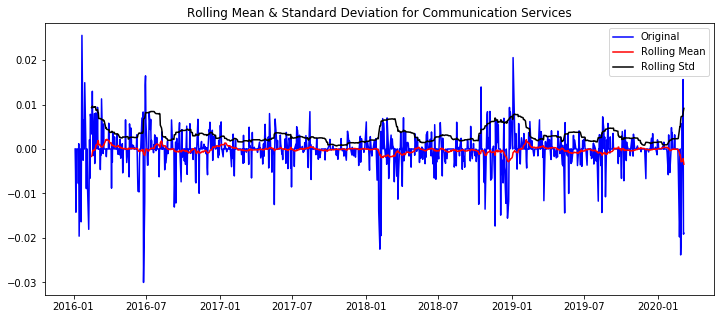

Consumer Cyclical
--------------------------------------------------------------------------------


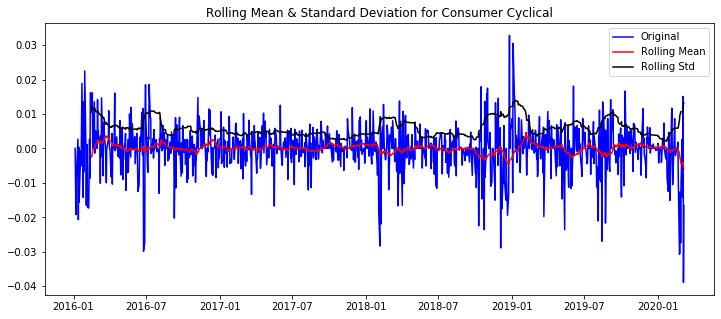

Consumer Defensive
--------------------------------------------------------------------------------


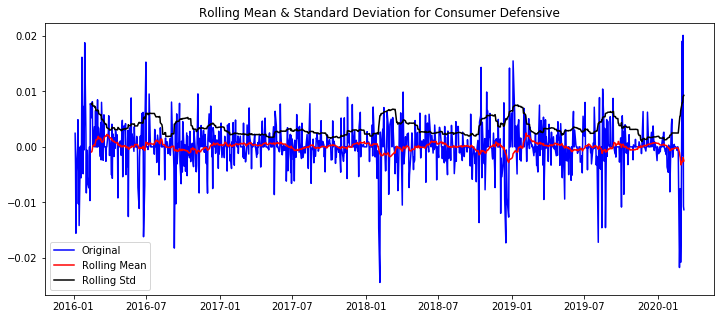

Diversified
--------------------------------------------------------------------------------


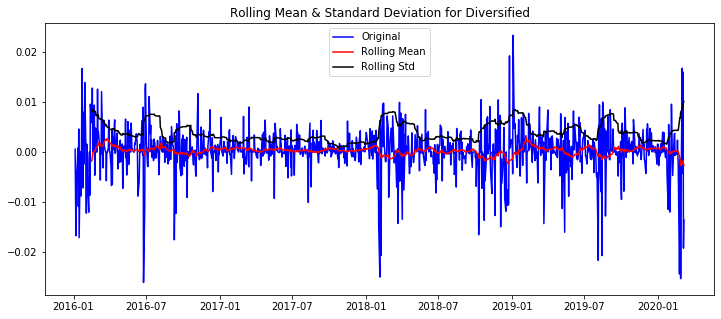

Energy
--------------------------------------------------------------------------------


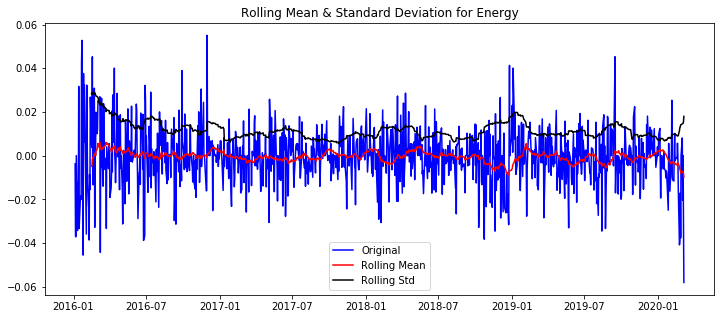

Financial
--------------------------------------------------------------------------------


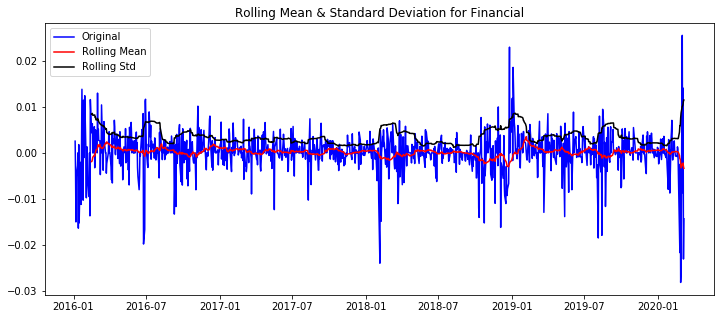

Healthcare
--------------------------------------------------------------------------------


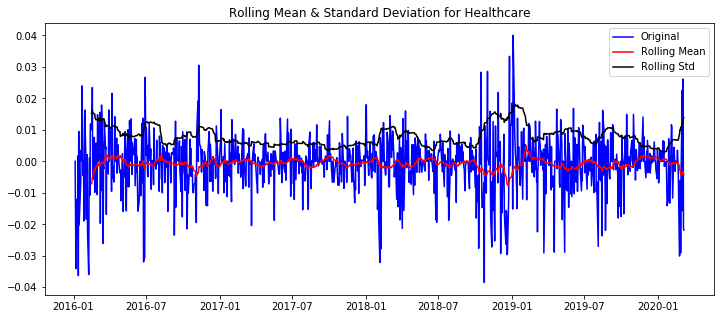

Industrials
--------------------------------------------------------------------------------


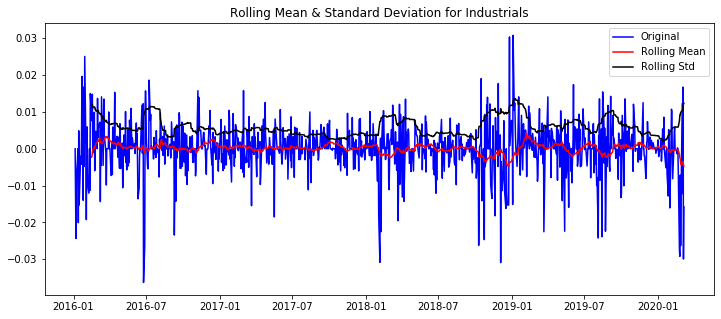

Real Estate
--------------------------------------------------------------------------------


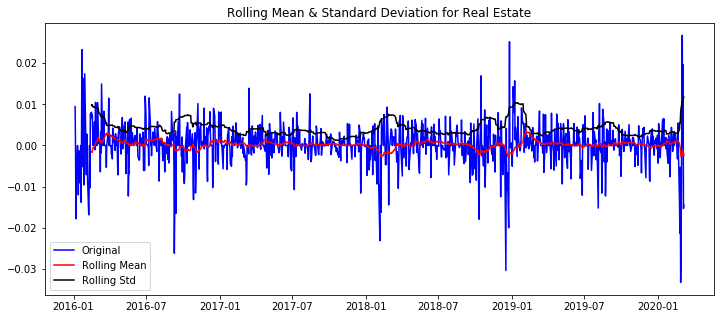

Technology
--------------------------------------------------------------------------------


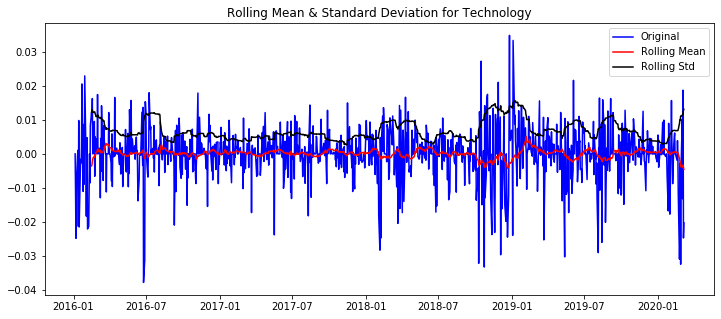

Utilities
--------------------------------------------------------------------------------


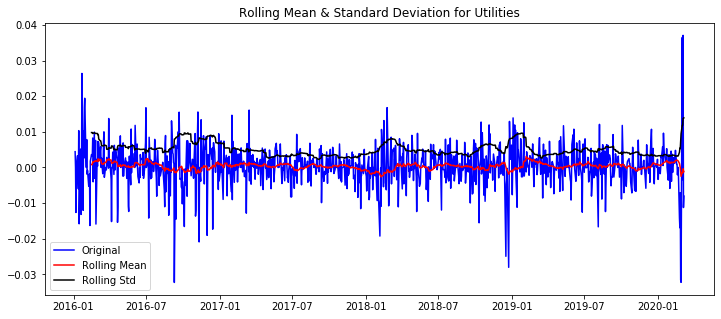

In [6]:
# 2.2. Visual Analysis - 1 month delta

window = 30 
print('30 days delta analysis')
print(100*'-')
for col in sector_composite.columns:
    rolling_plots(sector_composite, col, window=window, figsize=(10,4))

- On 30-day basis no trends noticable, but there is structural change (boost) in the beginning of 2019.
- It is possible to have some cycles related to quarterly financial statement issues, but such structure hardly seen here and those cycles' length not stable.
- In general, rolling means of all charts linear and close to 0. On the same time, there are small increases of rolling variation for some composites from 2019, which could indicate of heteroscedasticity.

On next stage we will look on ACF and PACF charts

Basic Materials
--------------------------------------------------------------------------------


<Figure size 720x144 with 0 Axes>

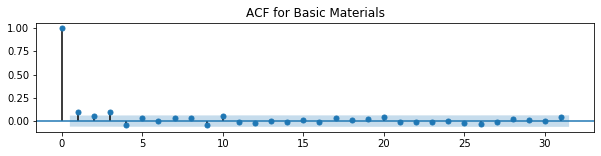

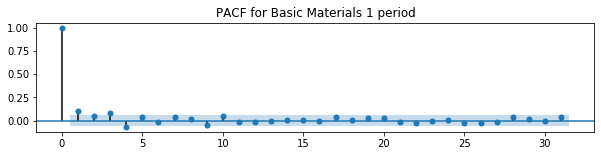

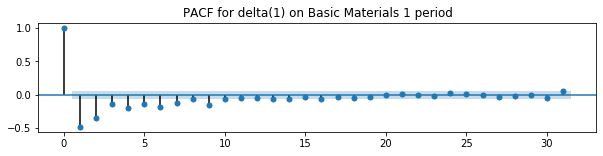

Communication Services
--------------------------------------------------------------------------------


<Figure size 720x144 with 0 Axes>

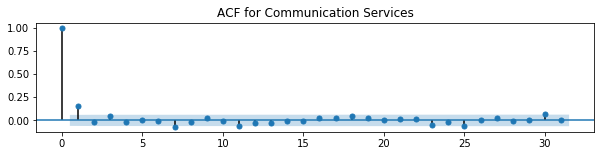

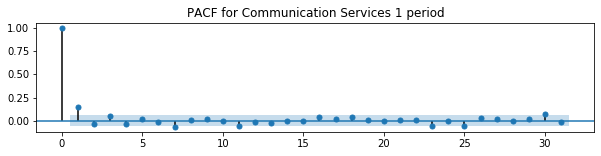

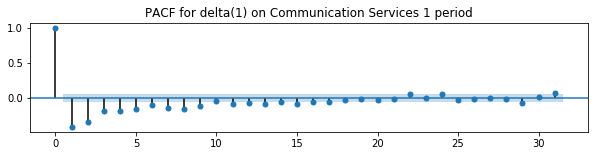

Consumer Cyclical
--------------------------------------------------------------------------------


<Figure size 720x144 with 0 Axes>

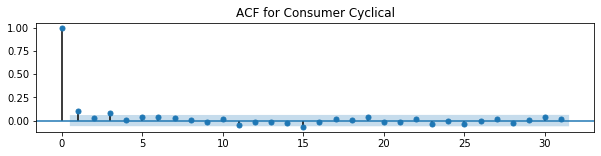

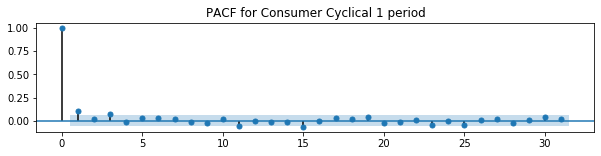

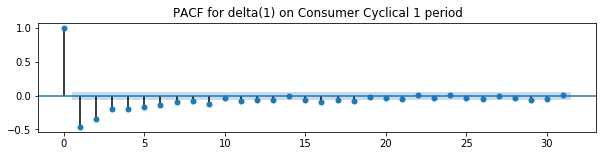

Consumer Defensive
--------------------------------------------------------------------------------


<Figure size 720x144 with 0 Axes>

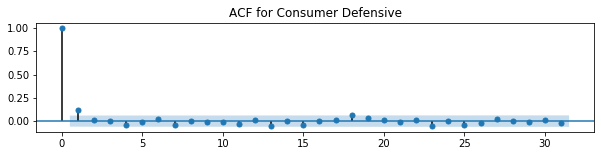

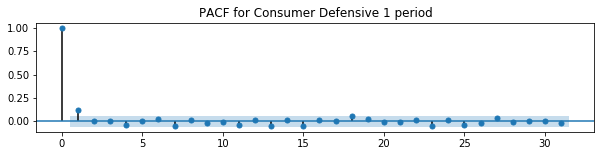

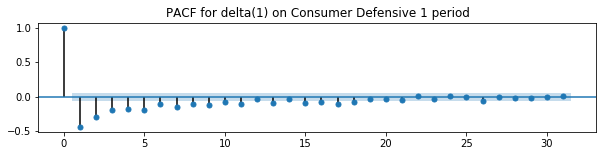

Diversified
--------------------------------------------------------------------------------


<Figure size 720x144 with 0 Axes>

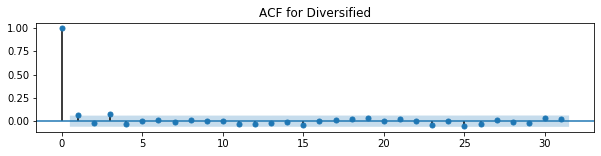

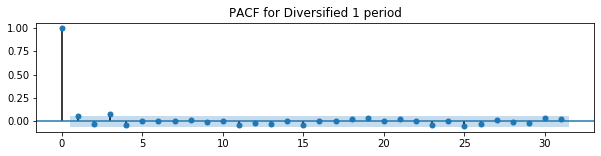

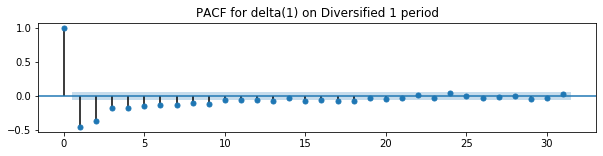

Energy
--------------------------------------------------------------------------------


<Figure size 720x144 with 0 Axes>

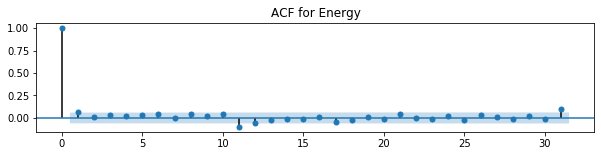

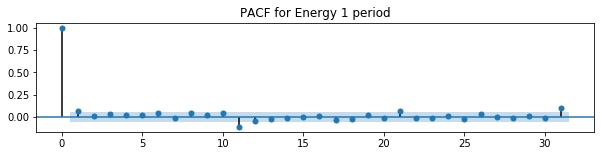

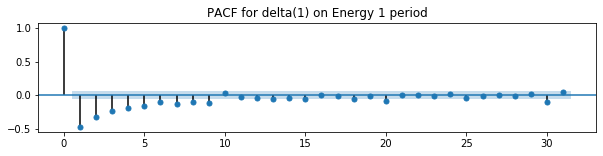

Financial
--------------------------------------------------------------------------------


<Figure size 720x144 with 0 Axes>

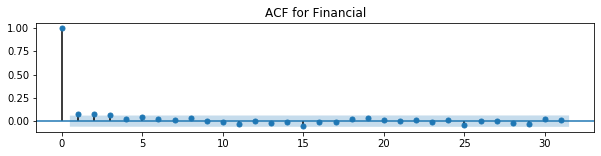

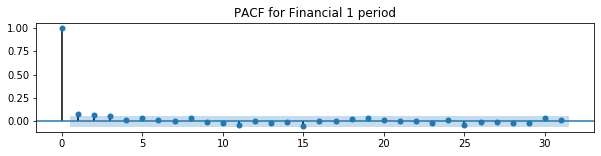

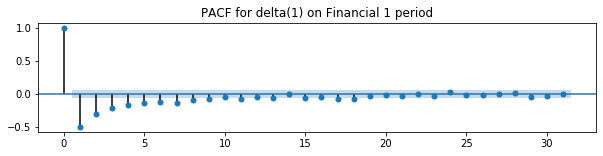

Healthcare
--------------------------------------------------------------------------------


<Figure size 720x144 with 0 Axes>

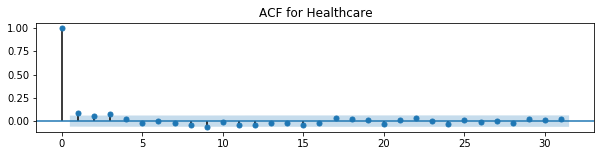

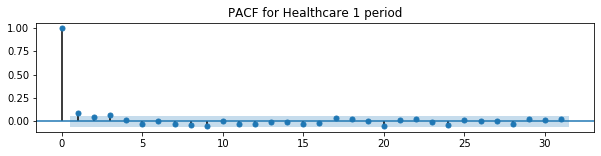

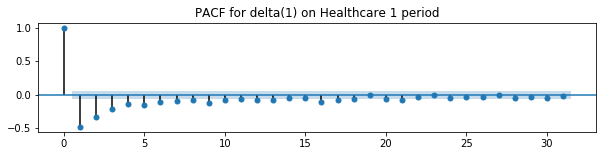

Industrials
--------------------------------------------------------------------------------


<Figure size 720x144 with 0 Axes>

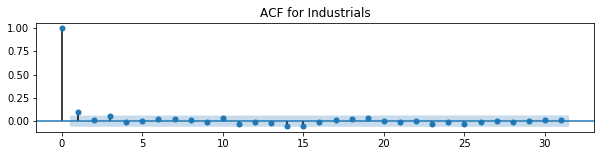

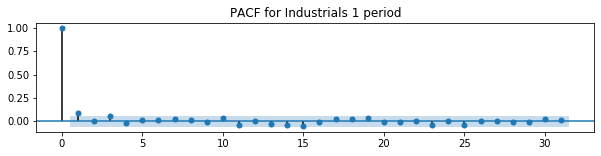

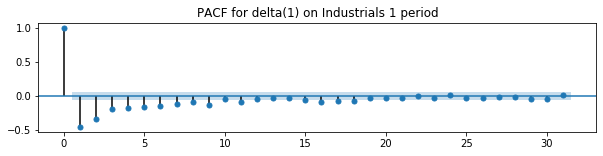

Real Estate
--------------------------------------------------------------------------------


<Figure size 720x144 with 0 Axes>

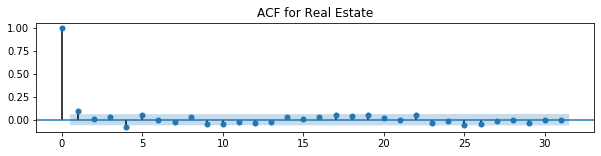

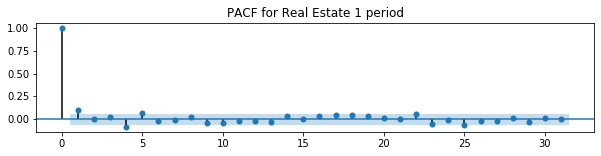

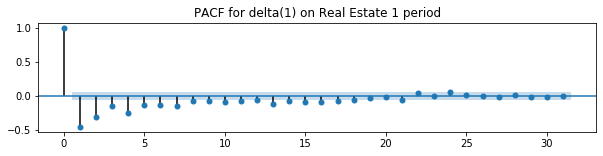

Technology
--------------------------------------------------------------------------------


<Figure size 720x144 with 0 Axes>

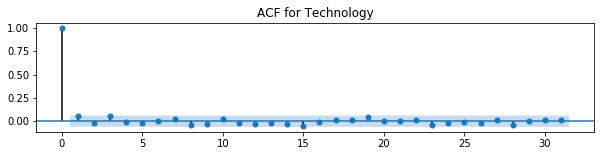

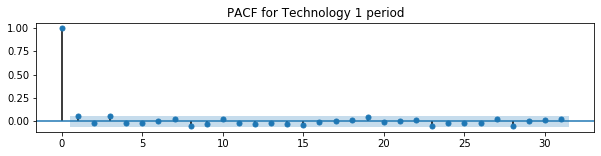

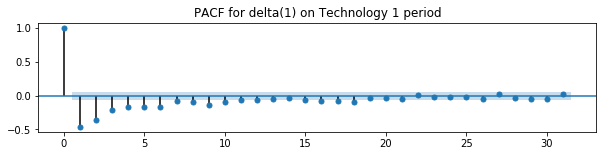

Utilities
--------------------------------------------------------------------------------


<Figure size 720x144 with 0 Axes>

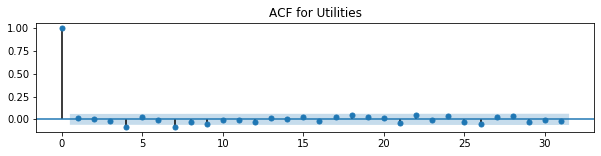

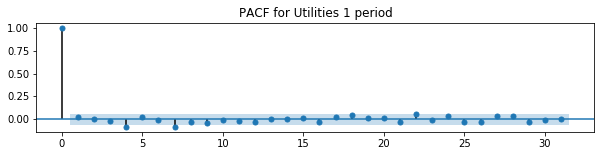

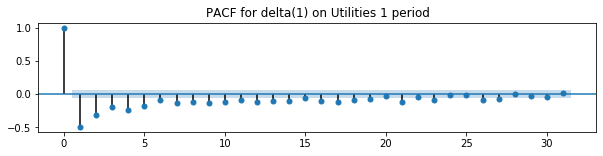

In [7]:
# 2.4. ACF and PACF
for col in sector_composite.columns:
    show_acf_pacf(sector_composite, col, add_delta=True, delta_step=1)

Shape of all charts  and parameters are similar

#### Hyperparameter tuning - for 1 random composite

In [8]:
# 3.1. choosing random composite
np.random.seed(42)
compos = np.random.randint(len(sector_composite.columns))
compos = sector_composite.iloc[:, compos]
print(f'randomly chosen time serie is {compos.name} composite')

randomly chosen time serie is Financial composite


In [9]:
# 3.2. ADF test
show_adf_test(compos)

ADF-test for Financial
Financial time series has stationarity
p-value = 0.0
--------------------------------------------------


In [10]:
# 3.3. HyperParams tuning
# attention: this cell can take several minutes

p_range = [0, 1, 2]
d_range = [0, 1]
q_range = [0, 1, 2]
s = 1
best_results_sector = dict()

start_time = time.time()
print(f'best params and AIC for {compos.name}')
print(50*'-')
best_params = find_optimal_params(compos, p_range, d_range, q_range, s, show_best_params=True)
print(f'..calculated in {(time.time() - start_time):.0f} sec')
print(50*'-')

best params and AIC for Financial
--------------------------------------------------
pdq        (0, 0, 0)
pdqs    (1, 0, 1, 1)
aic         -8677.92
Name: 7, dtype: object
..calculated in 119 sec
--------------------------------------------------


In [11]:
# 3.4. ARIMA model Summary on best params
compos_model = sm.tsa.statespace.SARIMAX(compos, order=best_params[0], seasonal_order=best_params[1],
                                            enforce_stationarity=False, enforce_invertibility=False)

compos_output = compos_model.fit()
compos_output.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Statespace Model Results                           
===============================================================================
Dep. Variable:               Financial   No. Observations:                 1082
Model:             SARIMAX(1, 0, 1, 1)   Log Likelihood                4341.962
Date:                 Sun, 22 Mar 2020   AIC                          -8677.923
Time:                         19:27:09   BIC                          -8662.969
Sample:                              0   HQIC                         -8672.261
                                - 1082                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L1        0.8317      0.037     22.739      0.000       0.760       0.903
ma.S.L1       -0.7726      0.041    -18.734      0.000      -0.853      -0.692
sigma2       1.88e-05   3.54e-07     53.077      0.000    1.81e-05    1.95e-05
===================================================================================
Ljung-Box (Q):                       14.95   Jarque-Bera (JB):              3371.56
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.50   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

r2 for forecasted 186 days: 1.36%


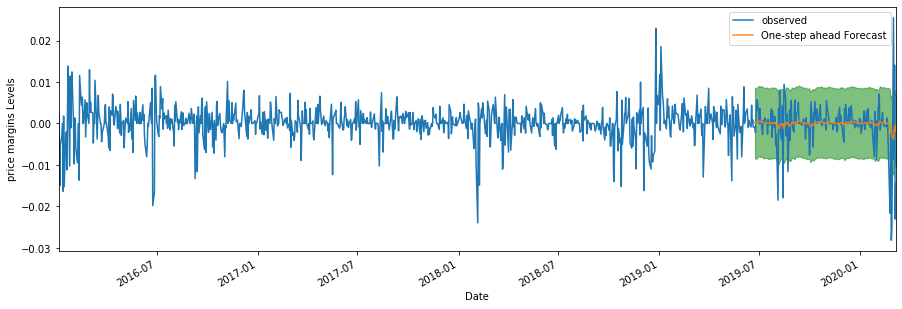

In [12]:
# 3.5. Forecast visualization and R2-score

forecast_start_date = '2019-06-24' # this is start date for TEST timeline

fig = plt.figure(figsize=(15,5))
pred = compos_output.get_prediction(start=pd.to_datetime(forecast_start_date), dynamic=False)
pred_conf = pred.conf_int()
ax = compos['2016':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)
ax.fill_between(pred_conf.index, pred_conf.iloc[:, 0], pred_conf.iloc[:, 1], color='g', alpha=.5)
ax.set_xlabel('Date')
ax.set_ylabel('price margins Levels')
plt.legend();
prices_forecasted = pred.predicted_mean
prices_true = compos[forecast_start_date:]
r2 = r2_score(prices_true,prices_forecasted  )
print(f'r2 for forecasted {len(prices_forecasted)} days: {100*r2:.2f}%')

As it shown above:
- forecast leads to zero because composite distributed around zero
- this fact confirms economic hypothesis of market fairness and zero profit, but does not serve the purpose of this project well
- giving the fact that
- Given the similar nature of all composites, the results of their modeling are likely to be similar.

This result is important for the next steps of the project and below, an attempt will be made to build predictive models based on already absolute normalized composite price values.

#### Statistical Diagnostic of Normalized Prices

In [13]:
# 4.1. Data Preparation

# 4.1.1. Collect all companies tickers per sector
sector_comps = dict()

for s in sector_test_comps.keys():
    sector_columns = sector_test_comps[s].T.columns
    sector_comps[s] = list(sector_columns)

# 4.1.2. Calculating composites for sectors
sector_composite_norm = sector_composite.copy()
for s in sector_composite_norm.columns:
    df = df_prices_norm[sector_comps[s]]
    composite = df.T.median()
    sector_composite_norm[s] = composite
    
# 4.1.3. Normalizing composites for clusters        
cluster_composite_norm = df_prices_norm[list(cluster_composite.columns)]

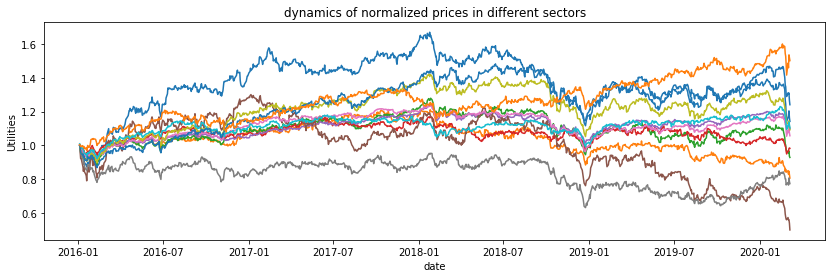

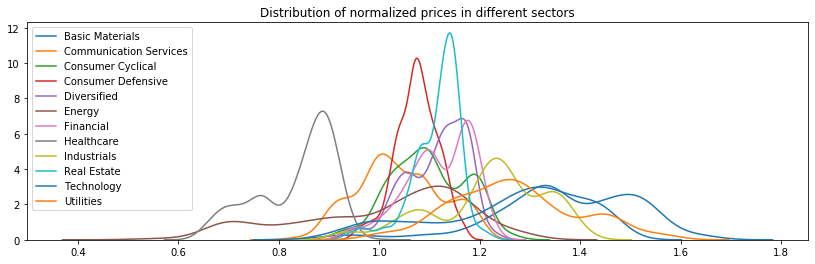

In [14]:
# 4.2. Visual look. Sector composites

plt.figure(figsize=(14,4))
for composite in sector_composite_norm.columns:
    sns.lineplot(x=sector_composite_norm.index, y=sector_composite_norm[composite] )
plt.title('dynamics of normalized prices in different sectors')
plt.show()

plt.figure(figsize=(14,4))
for composite in sector_composite_norm.columns:
    sns.kdeplot(sector_composite_norm[composite])
plt.title('Distribution of normalized prices in different sectors')
plt.show()

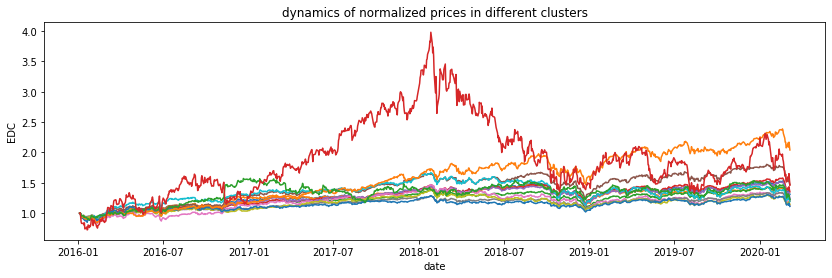

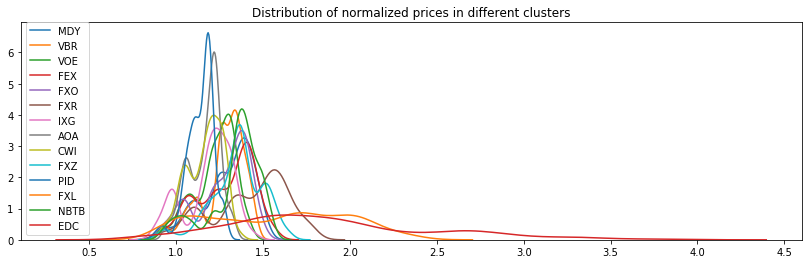

In [15]:
# 4.3. Visual look. Cluster composites

plt.figure(figsize=(14,4))
for composite in cluster_composite_norm.columns:
    sns.lineplot(x=cluster_composite_norm.index, y=cluster_composite_norm[composite], )
plt.title('dynamics of normalized prices in different clusters')
plt.show()

plt.figure(figsize=(14,4))
for composite in cluster_composite_norm.columns:
    sns.kdeplot(cluster_composite_norm[composite])
plt.title('Distribution of normalized prices in different clusters')
plt.show()

As shown above, KDE and dynamics of normalized prices significantly differ between each other and don't looks like white noise.

Let's repeat statistical tests from part 3 to these time series

7 days delta analysis
----------------------------------------------------------------------------------------------------
Basic Materials
--------------------------------------------------------------------------------


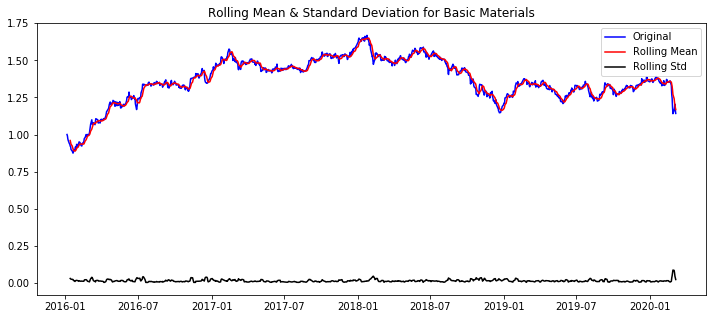

Communication Services
--------------------------------------------------------------------------------


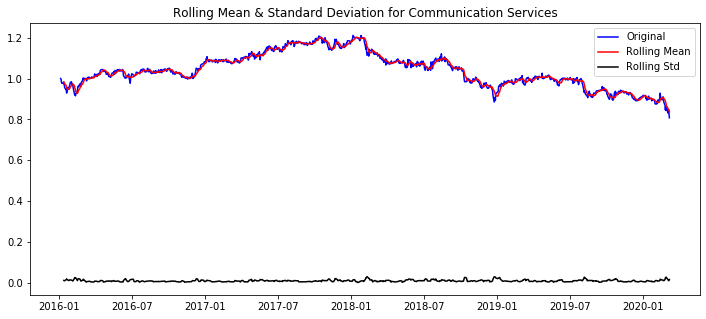

Consumer Cyclical
--------------------------------------------------------------------------------


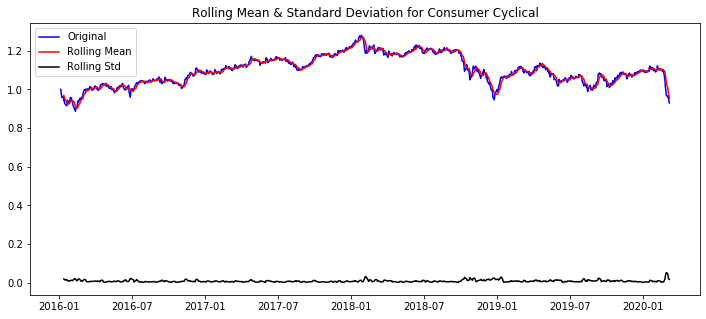

Consumer Defensive
--------------------------------------------------------------------------------


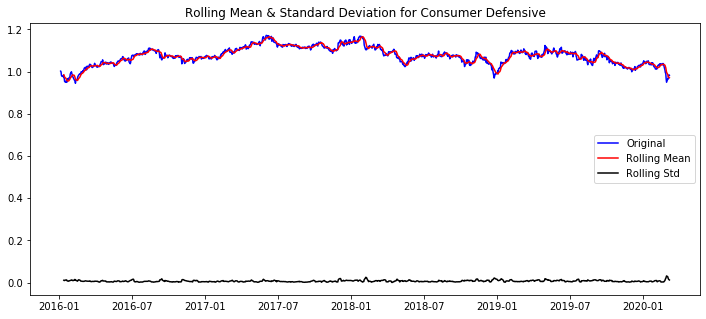

Diversified
--------------------------------------------------------------------------------


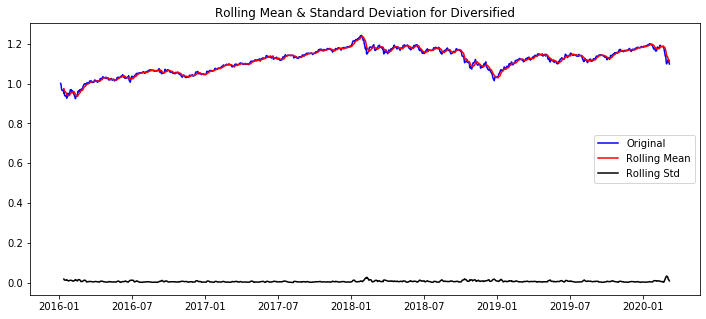

Energy
--------------------------------------------------------------------------------


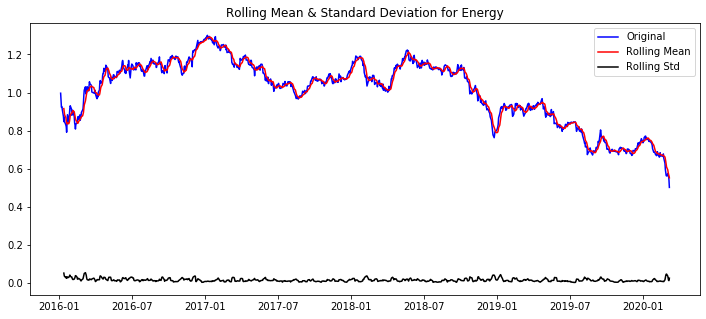

Financial
--------------------------------------------------------------------------------


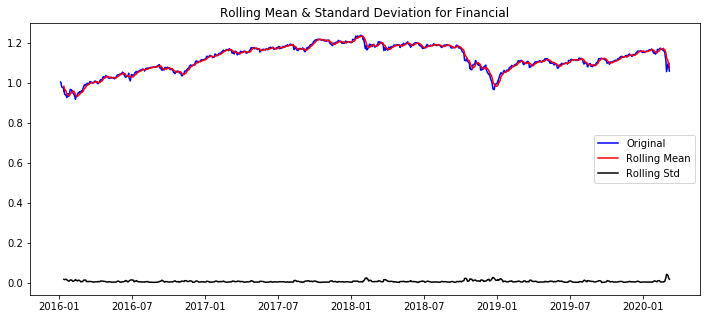

Healthcare
--------------------------------------------------------------------------------


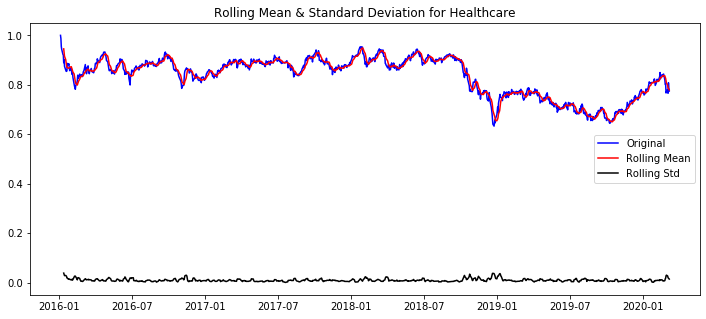

Industrials
--------------------------------------------------------------------------------


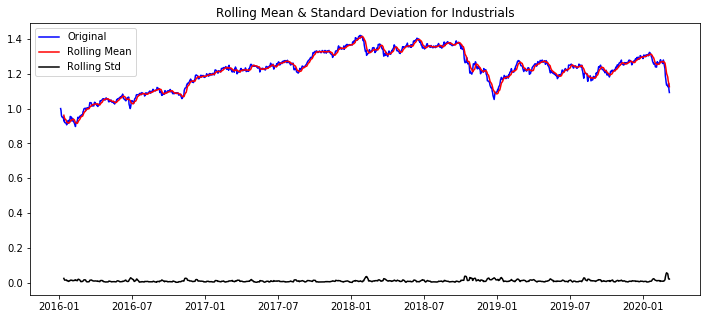

Real Estate
--------------------------------------------------------------------------------


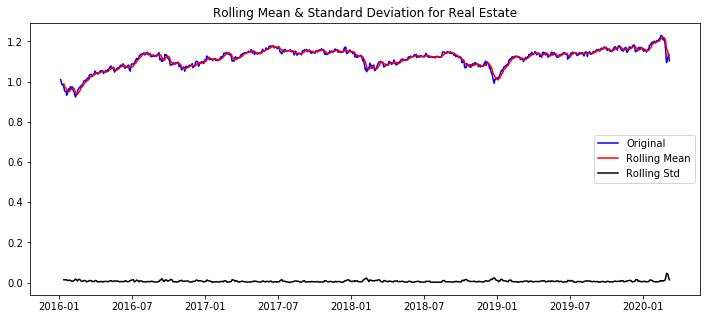

Technology
--------------------------------------------------------------------------------


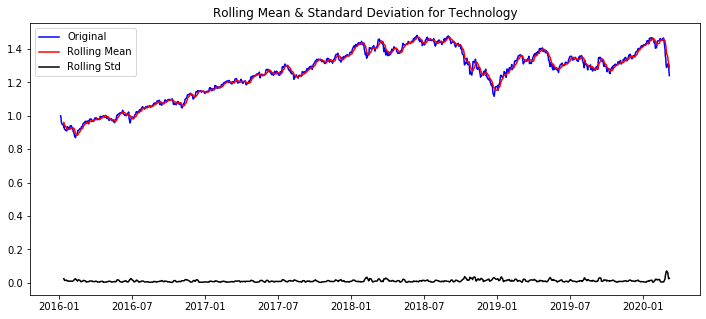

Utilities
--------------------------------------------------------------------------------


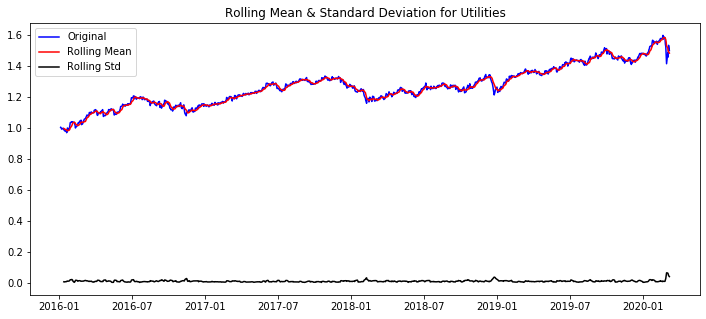

30 days delta analysis
----------------------------------------------------------------------------------------------------
Basic Materials
--------------------------------------------------------------------------------


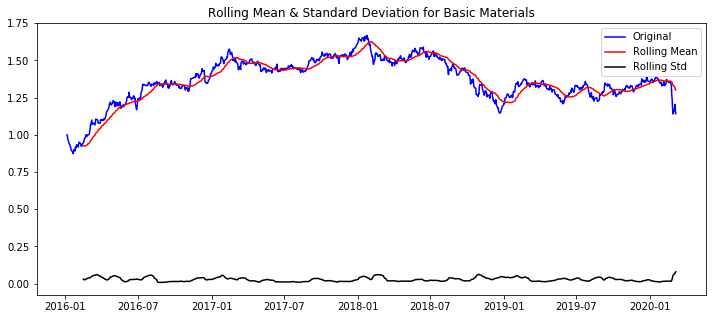

Communication Services
--------------------------------------------------------------------------------


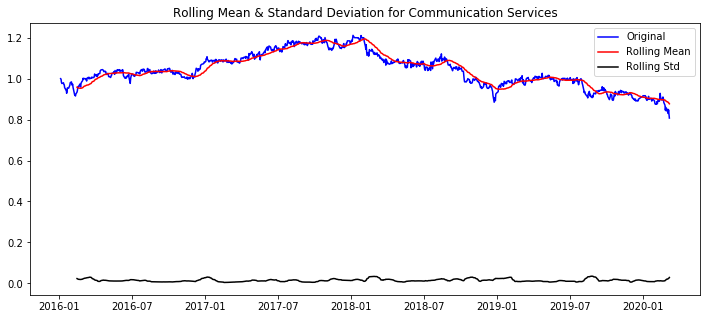

Consumer Cyclical
--------------------------------------------------------------------------------


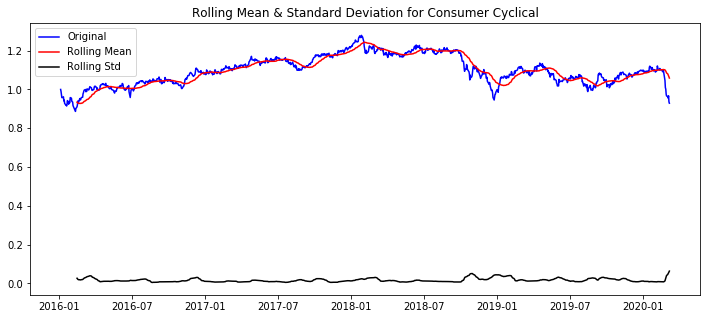

Consumer Defensive
--------------------------------------------------------------------------------


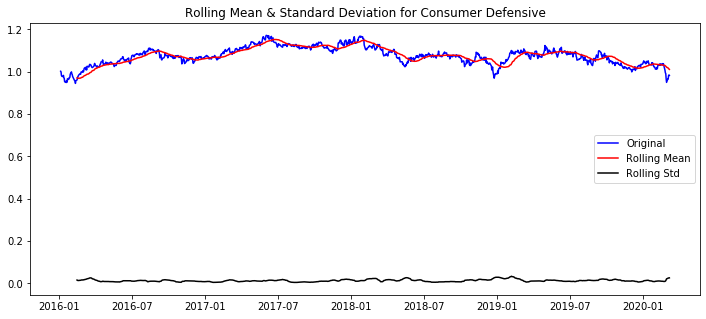

Diversified
--------------------------------------------------------------------------------


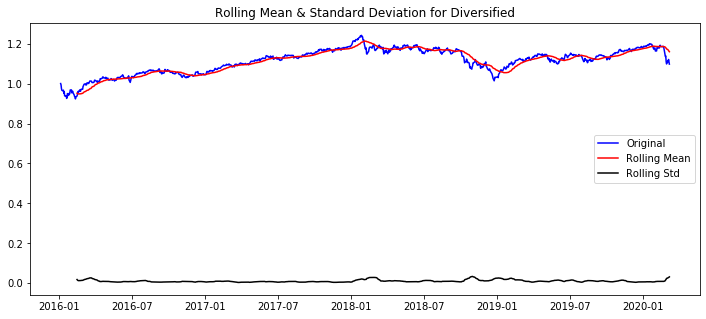

Energy
--------------------------------------------------------------------------------


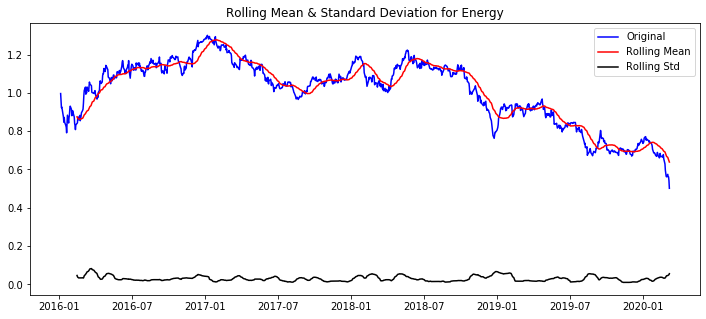

Financial
--------------------------------------------------------------------------------


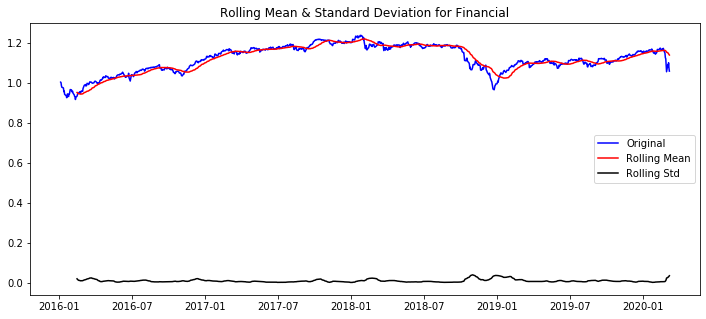

Healthcare
--------------------------------------------------------------------------------


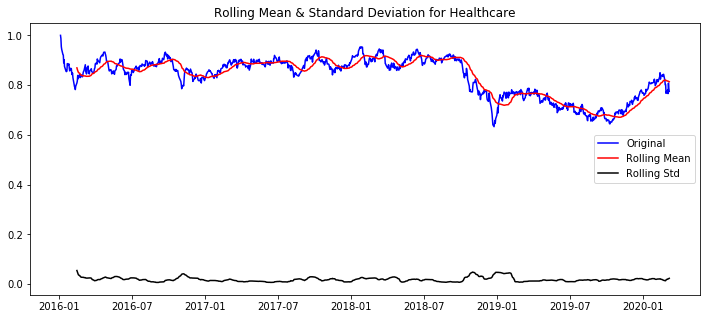

Industrials
--------------------------------------------------------------------------------


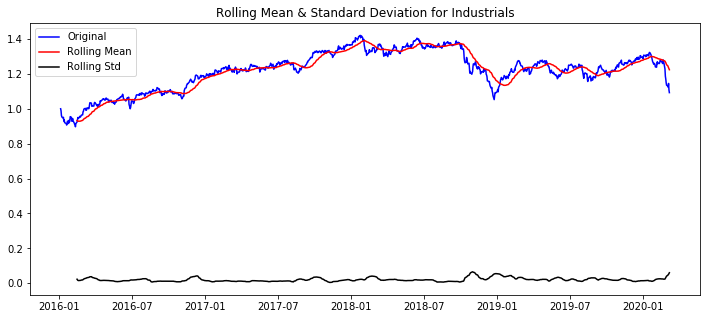

Real Estate
--------------------------------------------------------------------------------


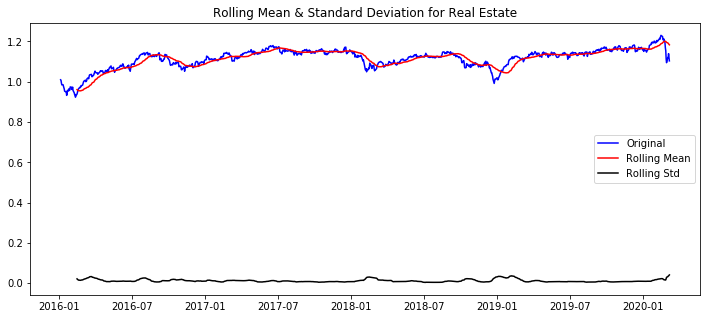

Technology
--------------------------------------------------------------------------------


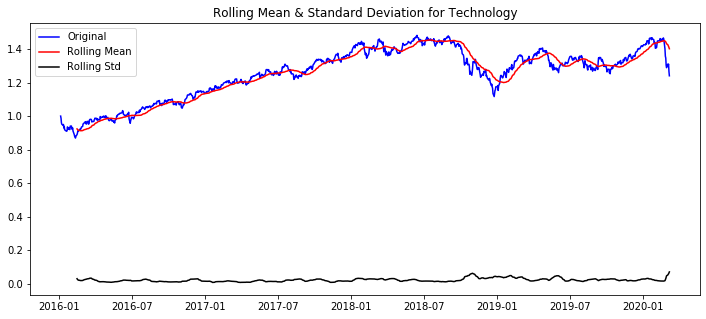

Utilities
--------------------------------------------------------------------------------


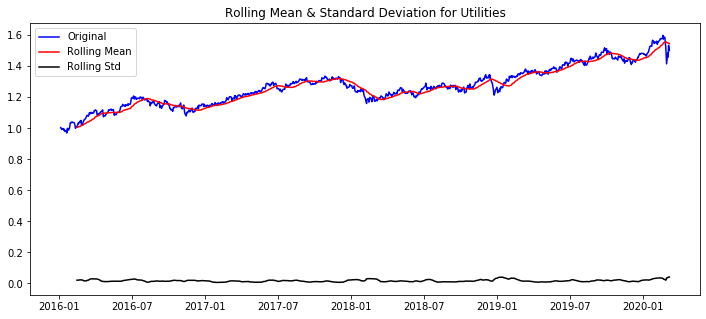

In [16]:
# 4.4. Rolling means and std for 7 days and 30 days periods for sector composites

window = 7
print('7 days delta analysis')
print(100*'-')
for col in sector_composite_norm.columns:
    rolling_plots(sector_composite_norm, col, window=window, figsize=(10,4))
    
window = 30
print('30 days delta analysis')
print(100*'-')
for col in sector_composite_norm.columns:
    rolling_plots(sector_composite_norm, col, window=window, figsize=(10,4))

7 days delta analysis
----------------------------------------------------------------------------------------------------
MDY
--------------------------------------------------------------------------------


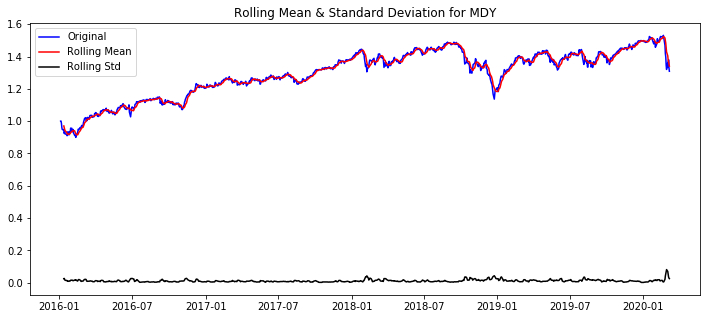

VBR
--------------------------------------------------------------------------------


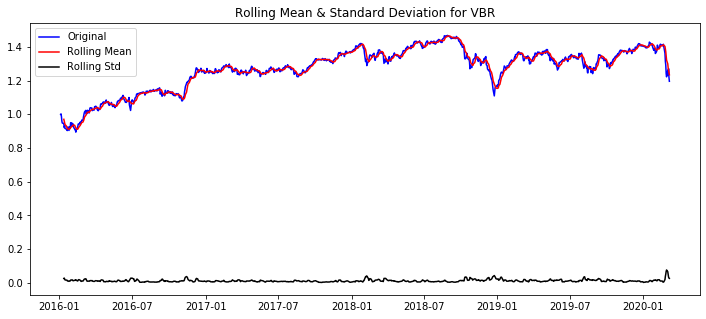

VOE
--------------------------------------------------------------------------------


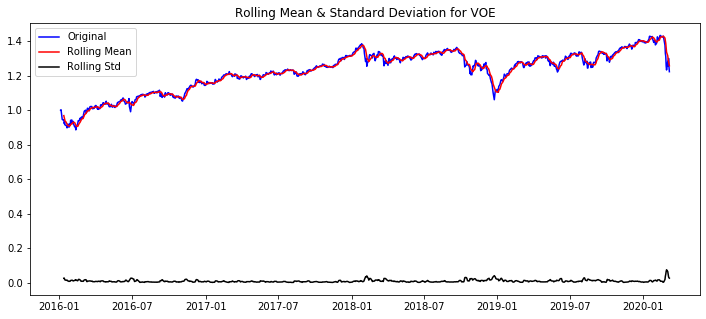

FEX
--------------------------------------------------------------------------------


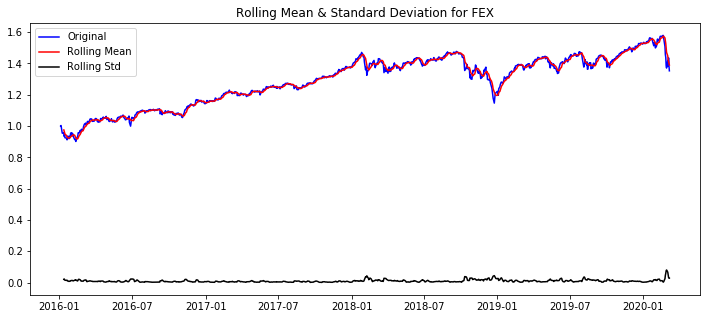

FXO
--------------------------------------------------------------------------------


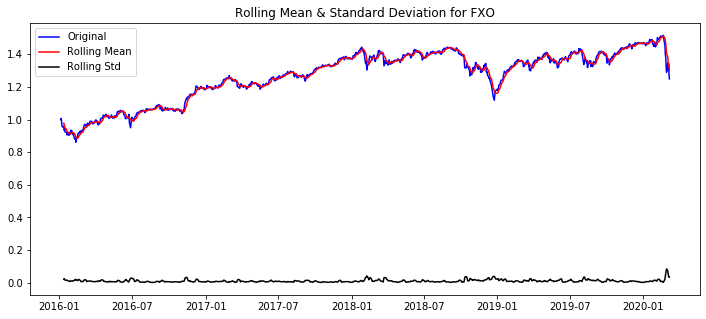

FXR
--------------------------------------------------------------------------------


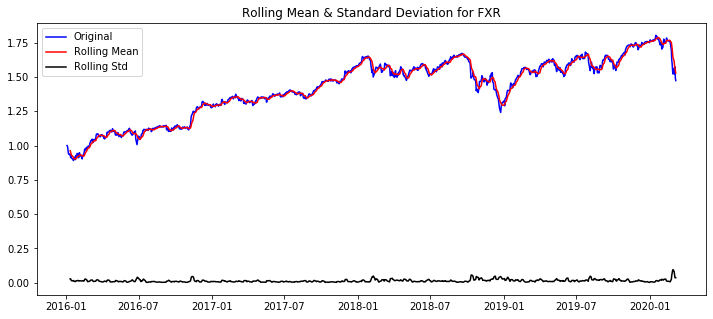

IXG
--------------------------------------------------------------------------------


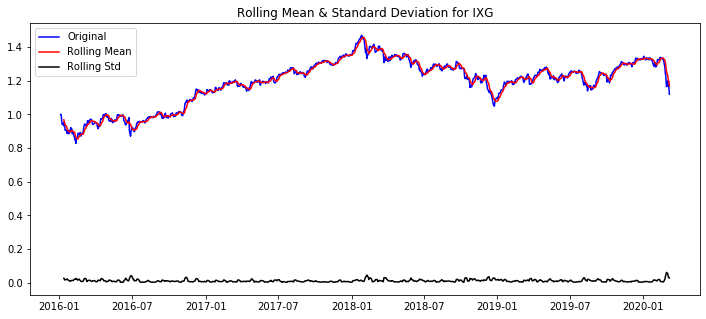

AOA
--------------------------------------------------------------------------------


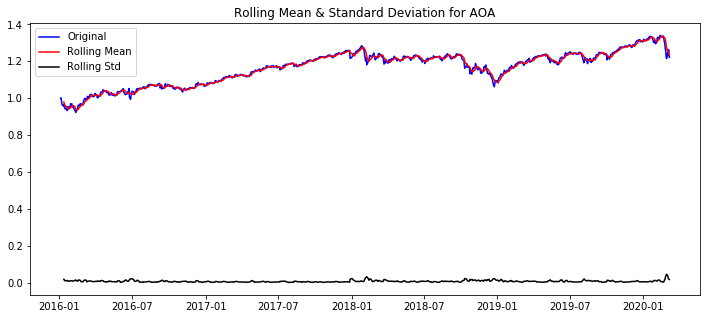

CWI
--------------------------------------------------------------------------------


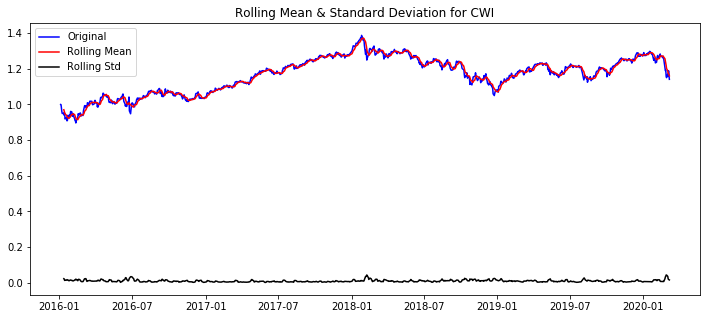

FXZ
--------------------------------------------------------------------------------


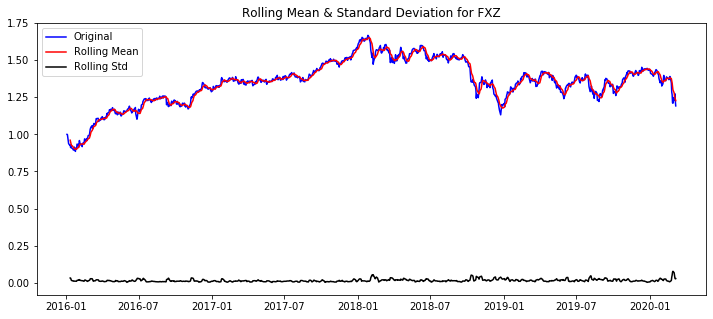

PID
--------------------------------------------------------------------------------


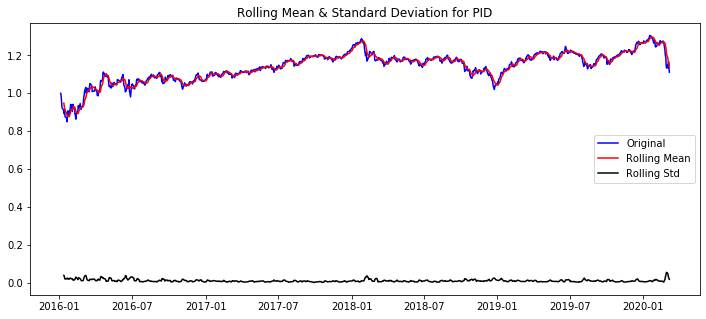

FXL
--------------------------------------------------------------------------------


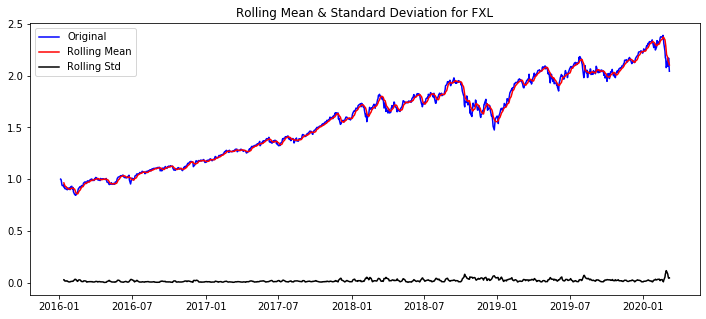

NBTB
--------------------------------------------------------------------------------


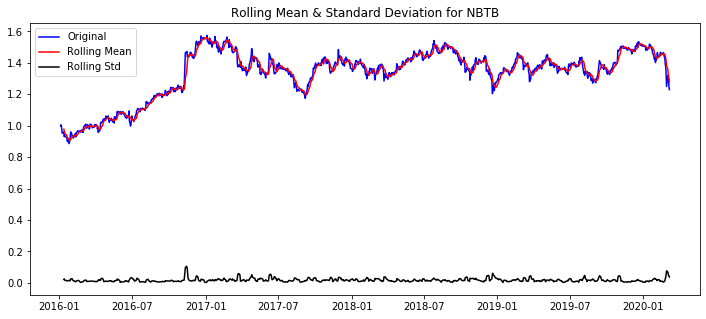

EDC
--------------------------------------------------------------------------------


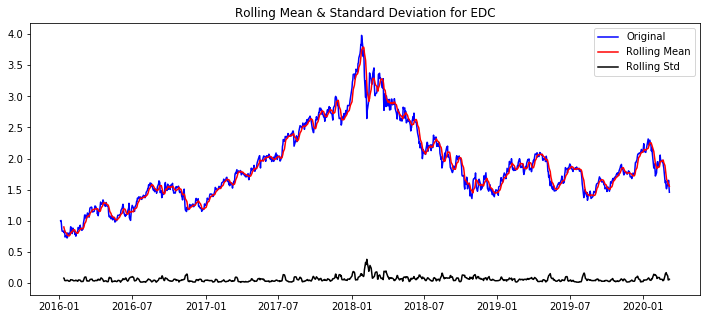

30 days delta analysis
----------------------------------------------------------------------------------------------------
MDY
--------------------------------------------------------------------------------


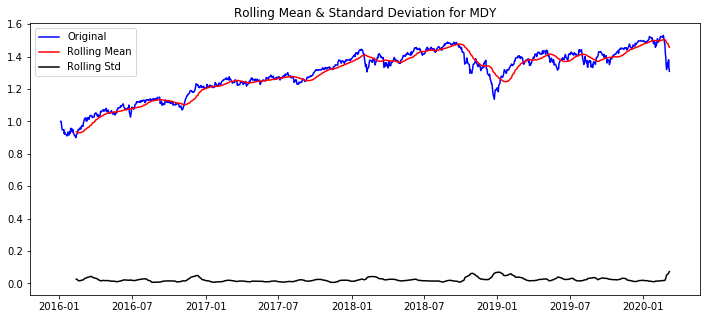

VBR
--------------------------------------------------------------------------------


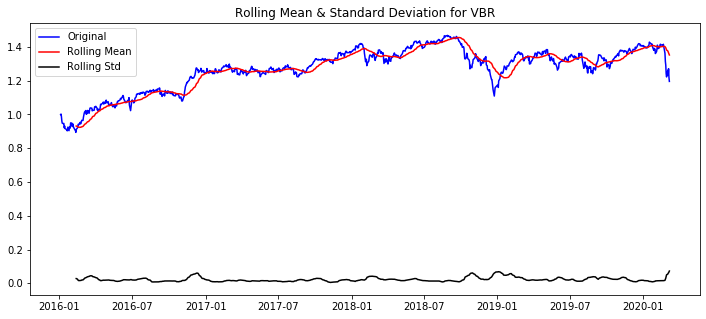

VOE
--------------------------------------------------------------------------------


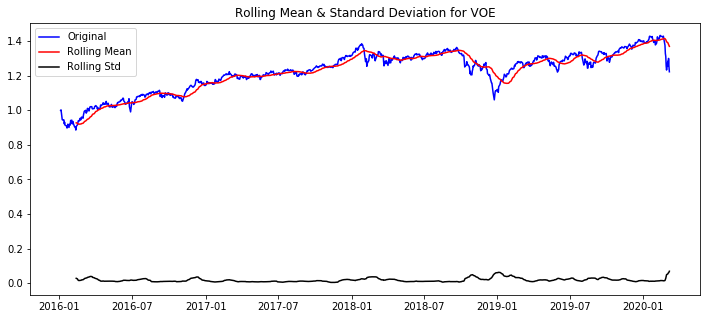

FEX
--------------------------------------------------------------------------------


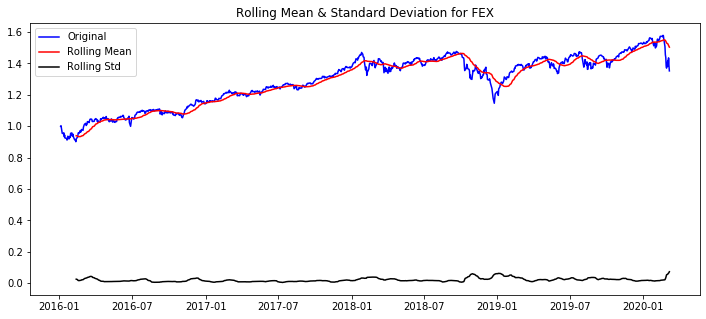

FXO
--------------------------------------------------------------------------------


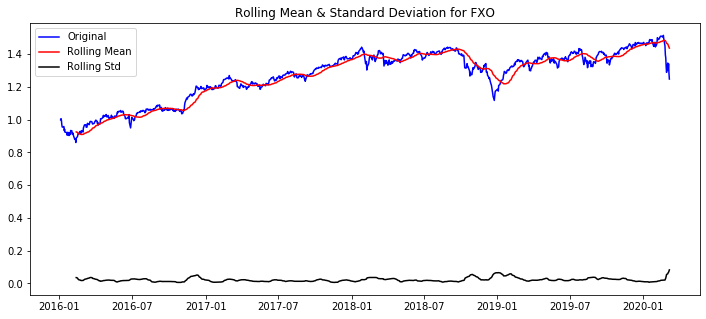

FXR
--------------------------------------------------------------------------------


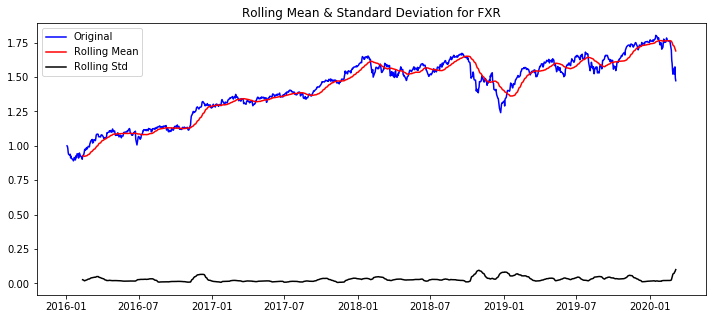

IXG
--------------------------------------------------------------------------------


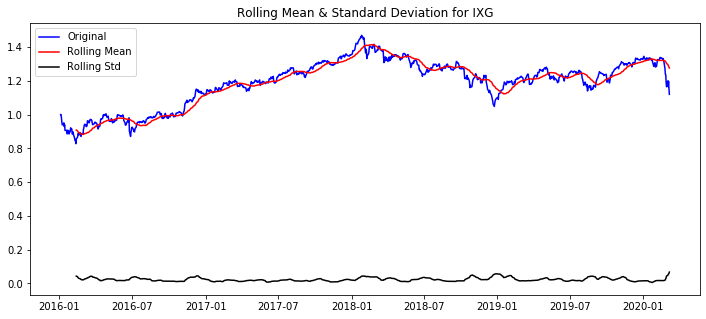

AOA
--------------------------------------------------------------------------------


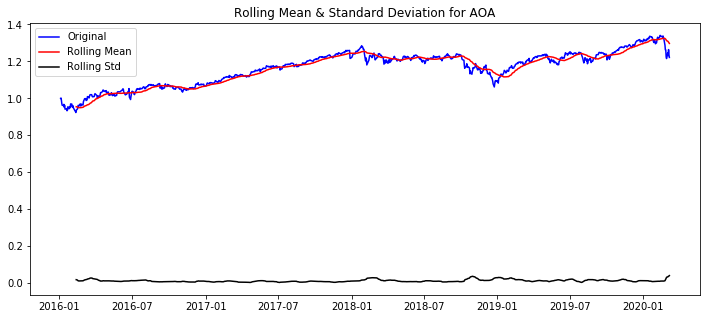

CWI
--------------------------------------------------------------------------------


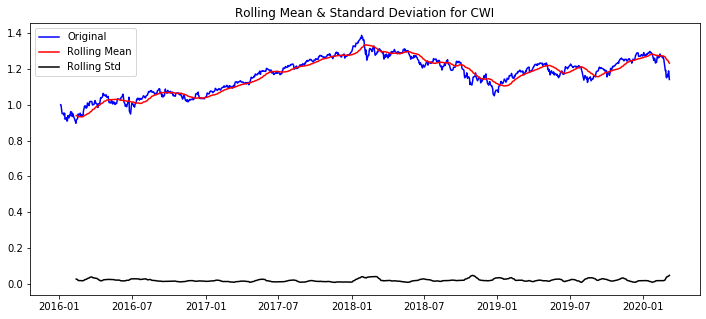

FXZ
--------------------------------------------------------------------------------


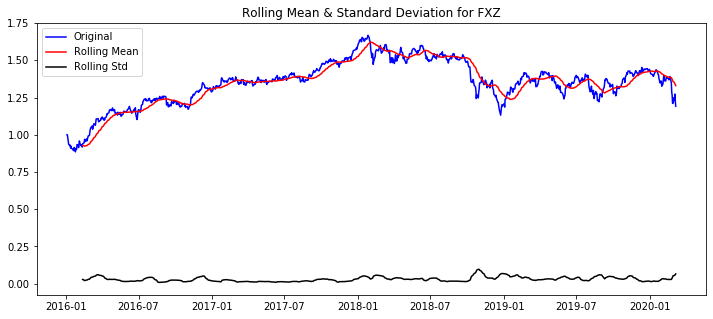

PID
--------------------------------------------------------------------------------


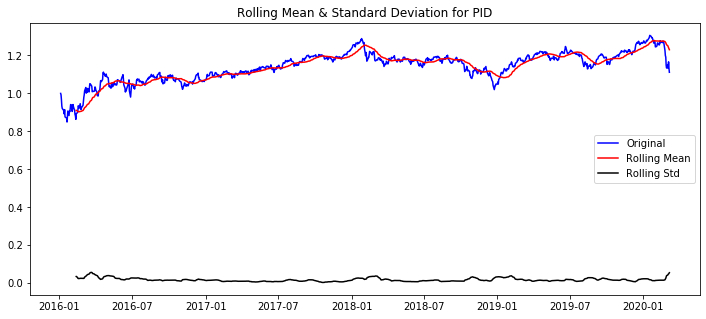

FXL
--------------------------------------------------------------------------------


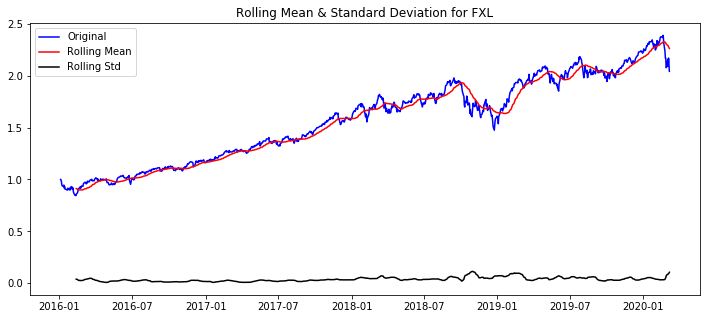

NBTB
--------------------------------------------------------------------------------


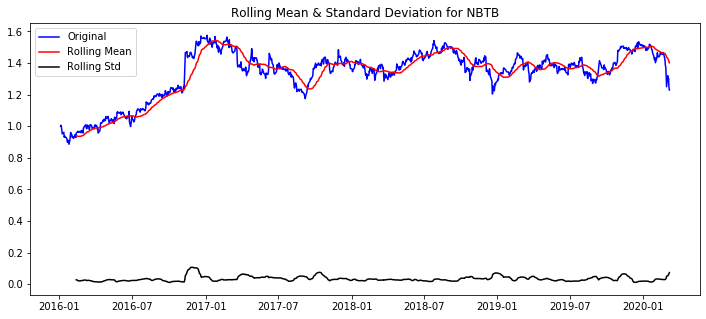

EDC
--------------------------------------------------------------------------------


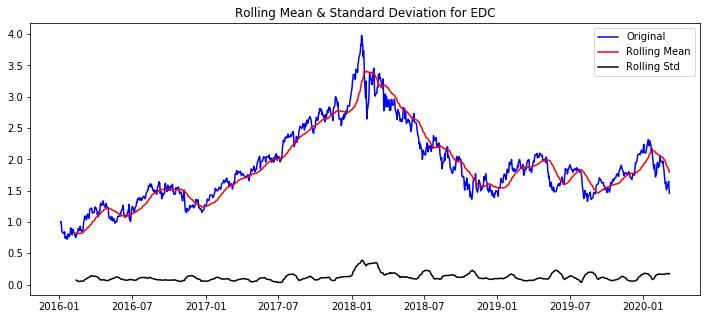

In [17]:
# 4.5. Rolling means and std for 7 days and 30 days periods for cluster centers

window = 7
print('7 days delta analysis')
print(100*'-')
for col in cluster_composite_norm.columns:
    rolling_plots(cluster_composite_norm, col, window=window, figsize=(10,4))
    
window = 30
print('30 days delta analysis')
print(100*'-')
for col in cluster_composite_norm.columns:
    rolling_plots(cluster_composite_norm, col, window=window, figsize=(10,4))

Trends start to look clearlier by increasing window size.  
It is important to say, that direction and shape of possible trends are different for different time series.  
Seasonality is weak and unstable.  
The dispersion is stable.  

In [18]:
# 4.6. ADF-tests

for col in sector_composite_norm.columns:
    show_adf_test(sector_composite_norm[col])
    
for col in cluster_composite_norm.columns:
    show_adf_test(cluster_composite_norm[col])

ADF-test for Basic Materials
Basic Materials time series has no stationarity!
p-value = 0.1361773745814922
--------------------------------------------------
ADF-test for Communication Services
Communication Services time series has no stationarity!
p-value = 0.8980852771399938
--------------------------------------------------
ADF-test for Consumer Cyclical
Consumer Cyclical time series has no stationarity!
p-value = 0.5087255120578507
--------------------------------------------------
ADF-test for Consumer Defensive
Consumer Defensive time series has no stationarity!
p-value = 0.07740552112934071
--------------------------------------------------
ADF-test for Diversified
Diversified time series has no stationarity!
p-value = 0.10709808727158188
--------------------------------------------------
ADF-test for Energy
Energy time series has no stationarity!
p-value = 0.9709001827988253
--------------------------------------------------
ADF-test for Financial
Financial time series has no 

As expected, most of time series haven't stationarity. Hence, d-param will be added in hyperparam search.

Basic Materials
--------------------------------------------------------------------------------


<Figure size 720x144 with 0 Axes>

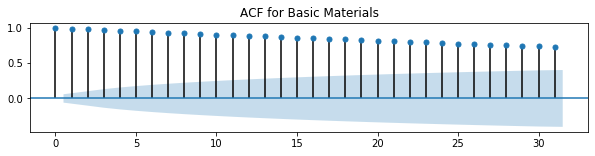

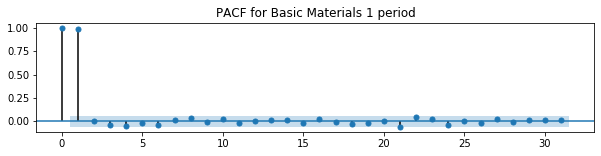

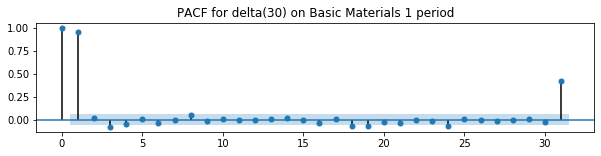

Communication Services
--------------------------------------------------------------------------------


<Figure size 720x144 with 0 Axes>

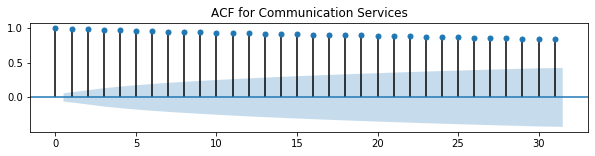

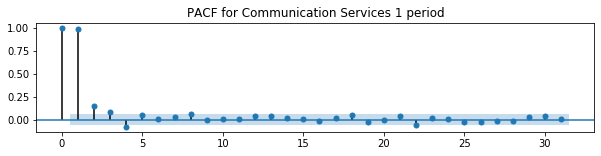

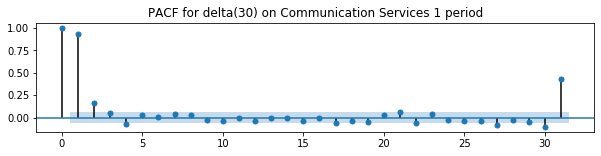

Consumer Cyclical
--------------------------------------------------------------------------------


<Figure size 720x144 with 0 Axes>

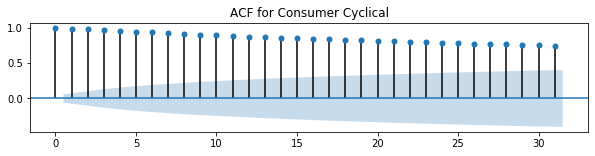

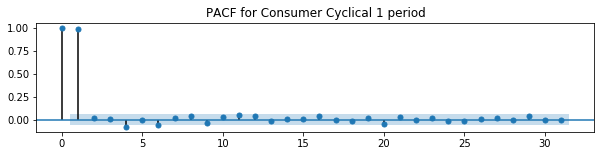

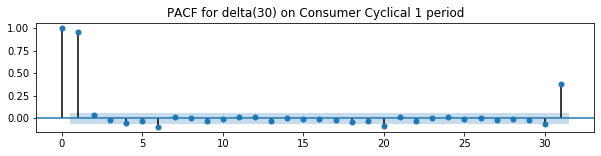

Consumer Defensive
--------------------------------------------------------------------------------


<Figure size 720x144 with 0 Axes>

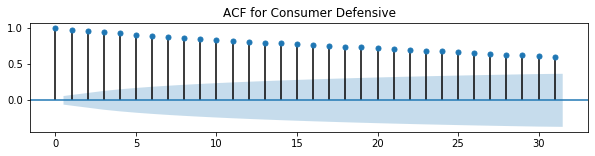

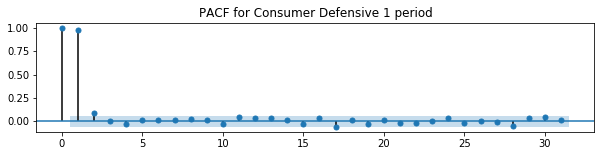

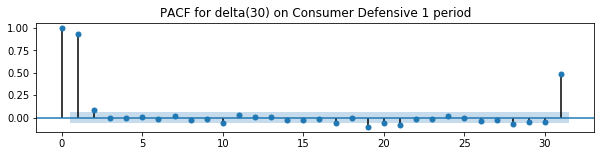

Diversified
--------------------------------------------------------------------------------


<Figure size 720x144 with 0 Axes>

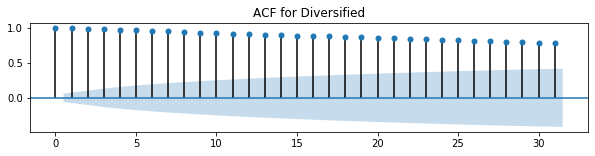

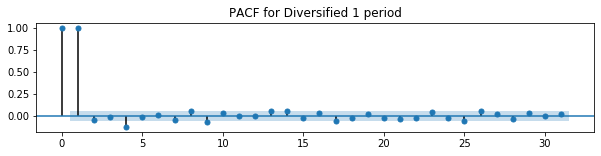

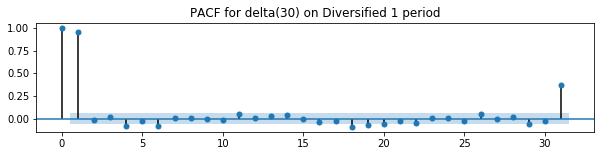

Energy
--------------------------------------------------------------------------------


<Figure size 720x144 with 0 Axes>

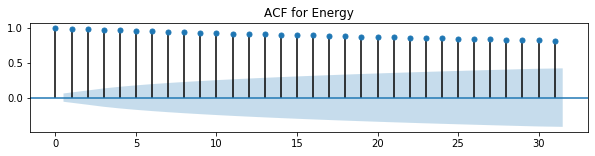

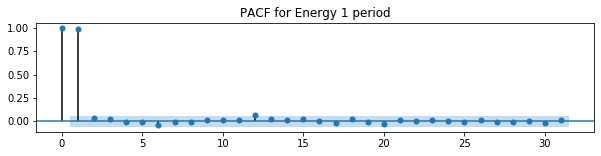

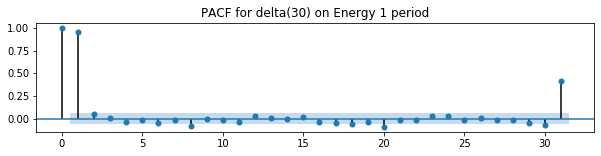

Financial
--------------------------------------------------------------------------------


<Figure size 720x144 with 0 Axes>

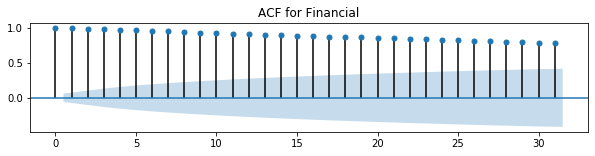

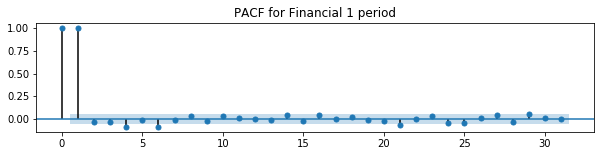

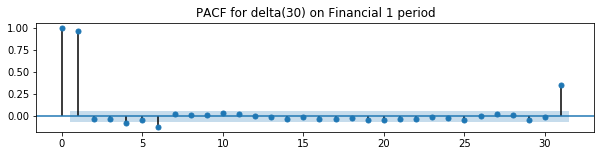

Healthcare
--------------------------------------------------------------------------------


<Figure size 720x144 with 0 Axes>

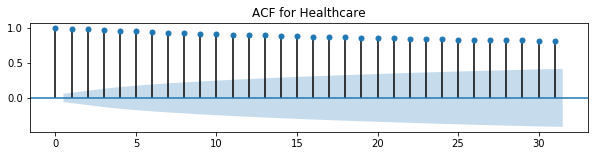

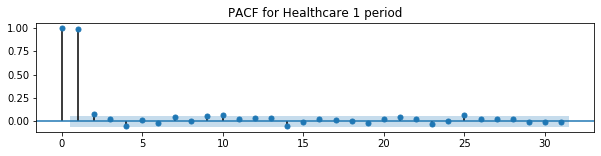

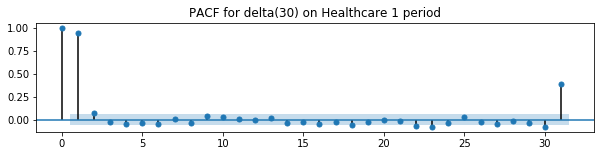

Industrials
--------------------------------------------------------------------------------


<Figure size 720x144 with 0 Axes>

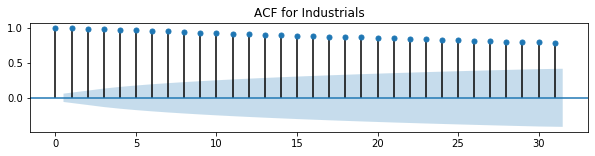

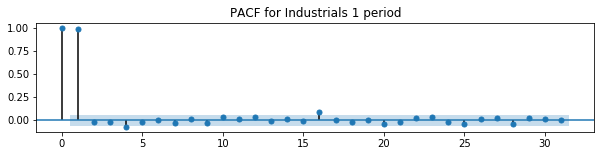

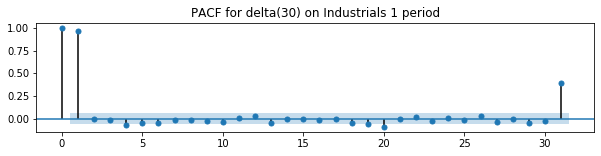

Real Estate
--------------------------------------------------------------------------------


<Figure size 720x144 with 0 Axes>

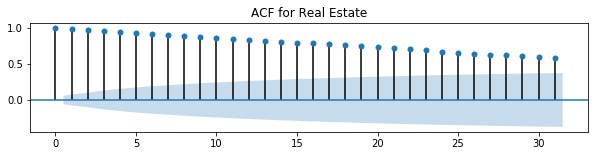

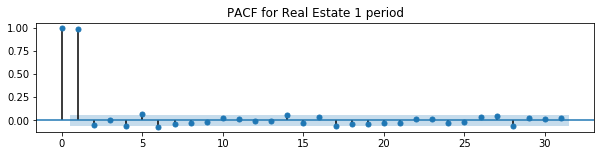

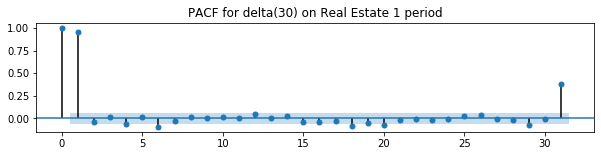

Technology
--------------------------------------------------------------------------------


<Figure size 720x144 with 0 Axes>

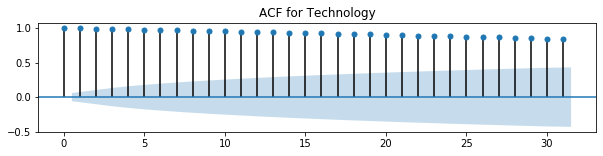

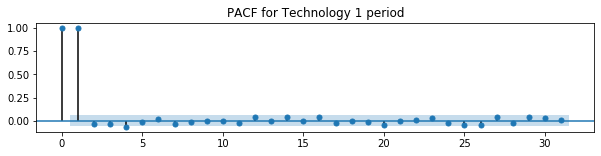

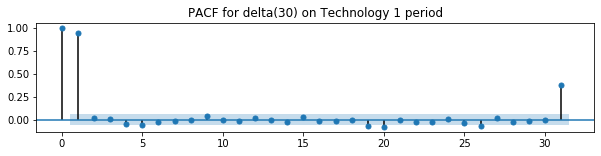

Utilities
--------------------------------------------------------------------------------


<Figure size 720x144 with 0 Axes>

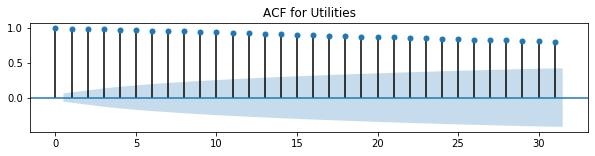

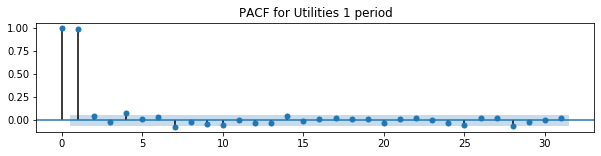

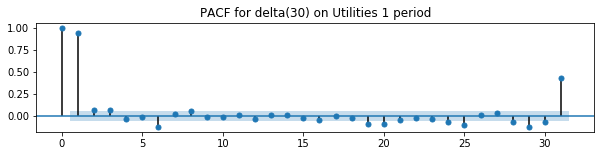

MDY
--------------------------------------------------------------------------------


<Figure size 720x144 with 0 Axes>

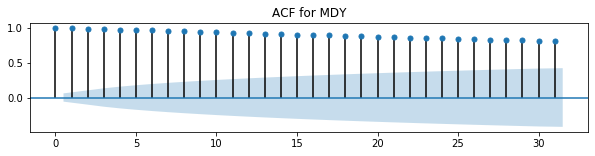

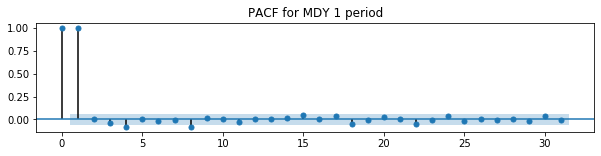

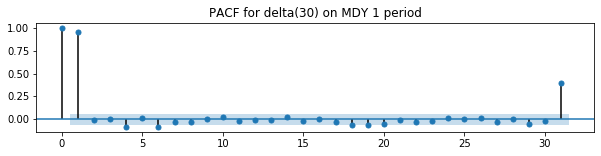

VBR
--------------------------------------------------------------------------------


<Figure size 720x144 with 0 Axes>

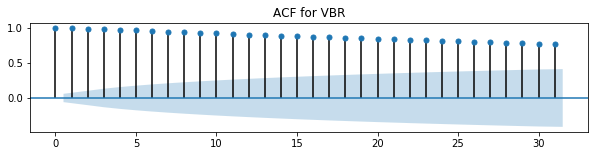

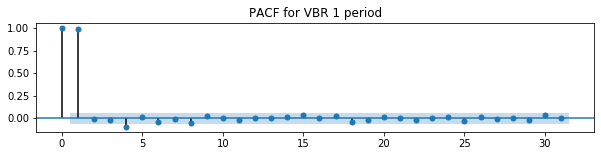

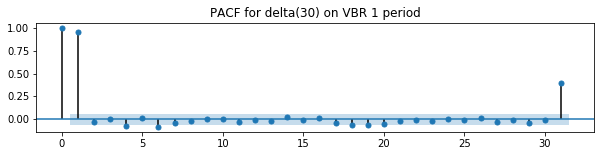

VOE
--------------------------------------------------------------------------------


<Figure size 720x144 with 0 Axes>

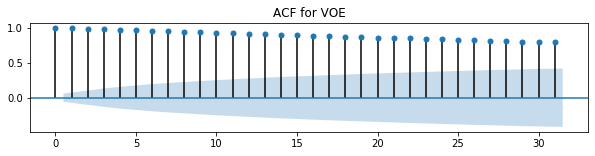

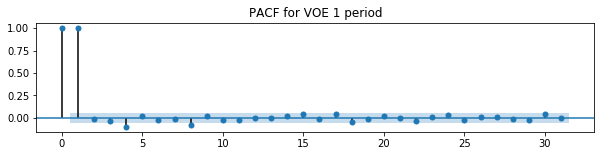

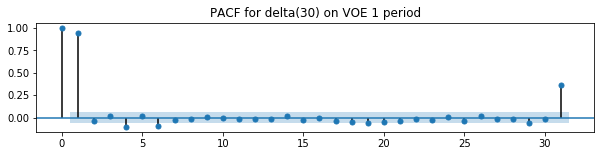

FEX
--------------------------------------------------------------------------------


<Figure size 720x144 with 0 Axes>

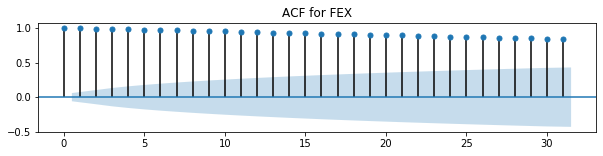

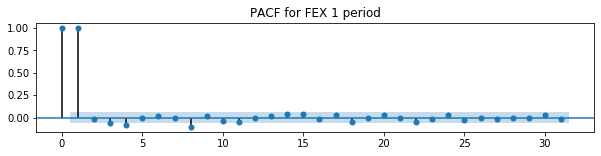

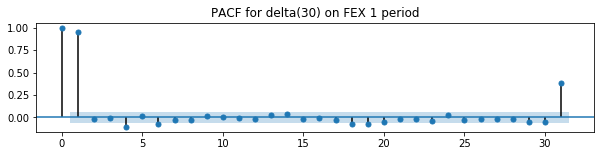

FXO
--------------------------------------------------------------------------------


<Figure size 720x144 with 0 Axes>

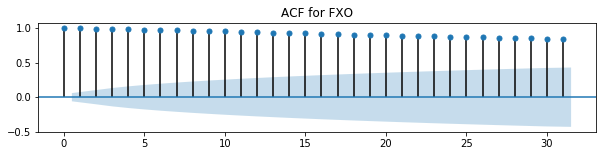

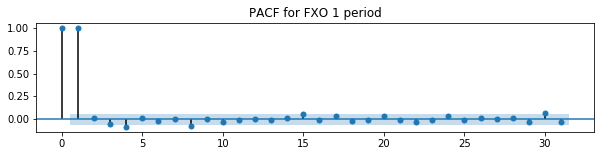

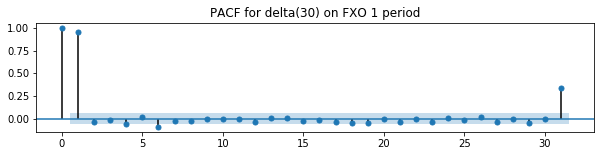

FXR
--------------------------------------------------------------------------------


<Figure size 720x144 with 0 Axes>

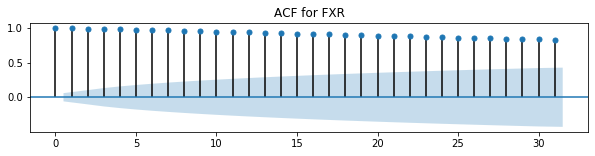

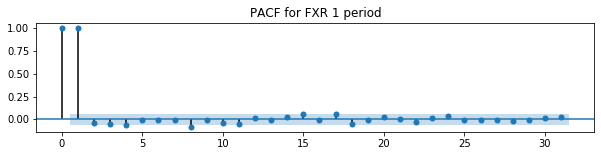

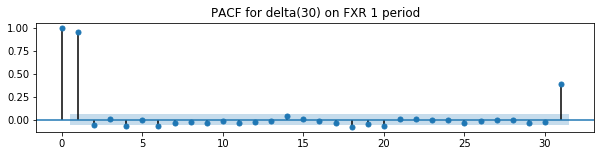

IXG
--------------------------------------------------------------------------------


<Figure size 720x144 with 0 Axes>

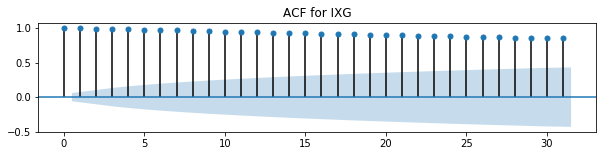

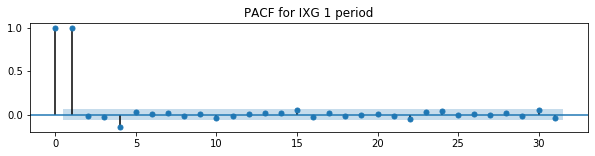

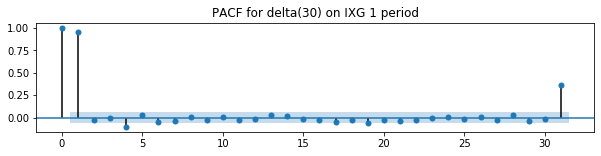

AOA
--------------------------------------------------------------------------------


<Figure size 720x144 with 0 Axes>

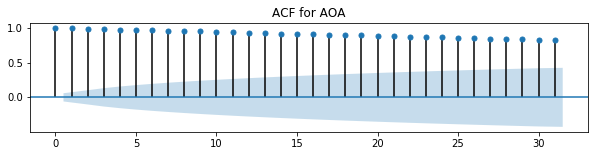

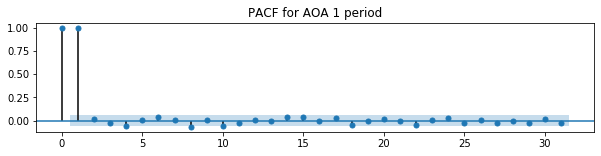

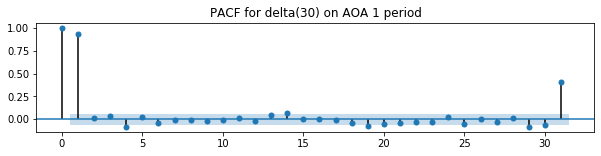

CWI
--------------------------------------------------------------------------------


<Figure size 720x144 with 0 Axes>

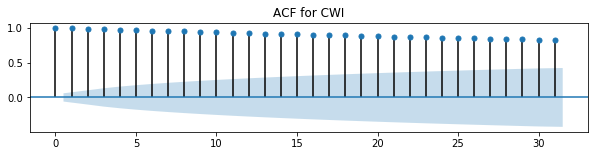

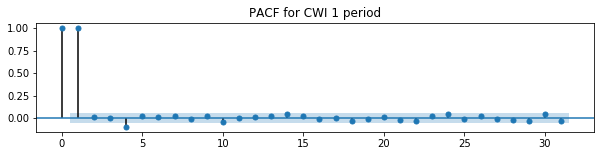

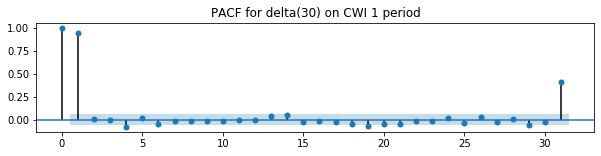

FXZ
--------------------------------------------------------------------------------


<Figure size 720x144 with 0 Axes>

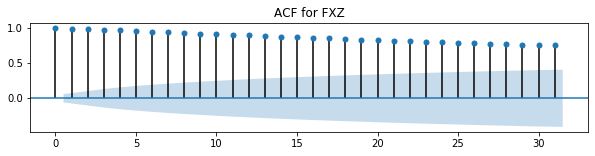

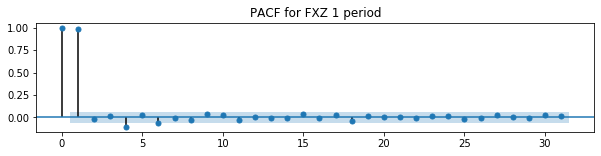

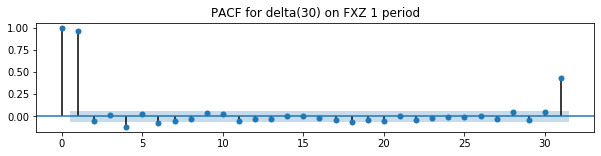

PID
--------------------------------------------------------------------------------


<Figure size 720x144 with 0 Axes>

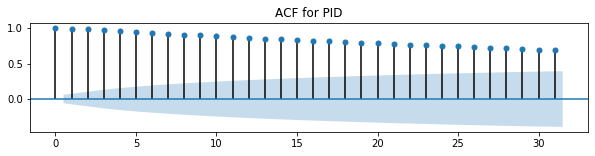

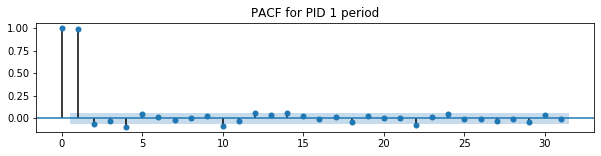

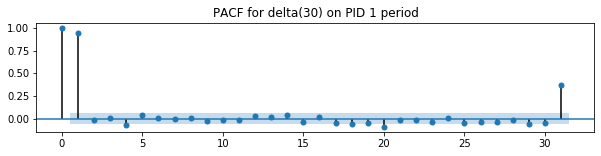

FXL
--------------------------------------------------------------------------------


<Figure size 720x144 with 0 Axes>

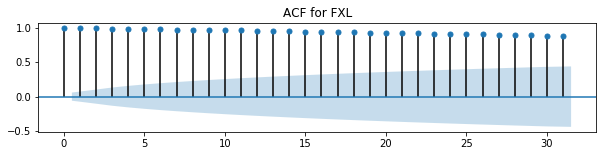

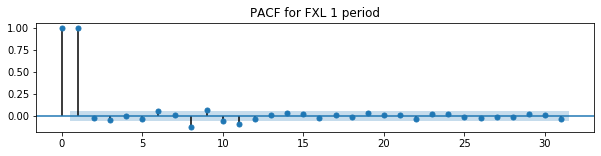

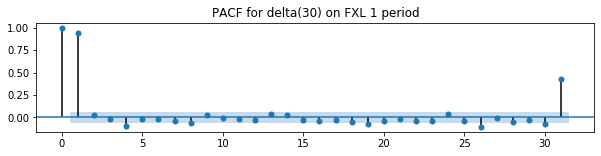

NBTB
--------------------------------------------------------------------------------


<Figure size 720x144 with 0 Axes>

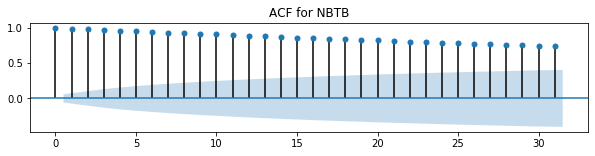

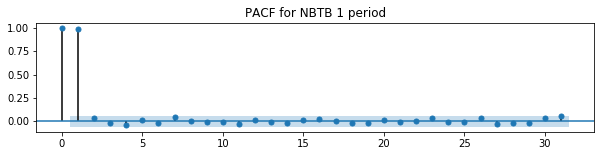

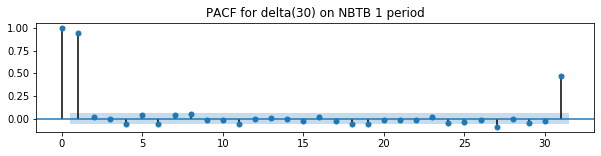

EDC
--------------------------------------------------------------------------------


<Figure size 720x144 with 0 Axes>

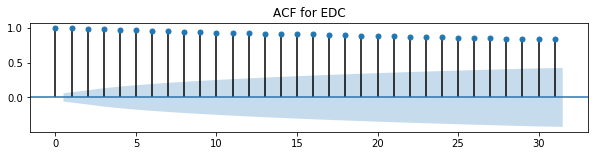

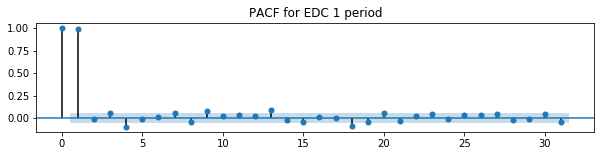

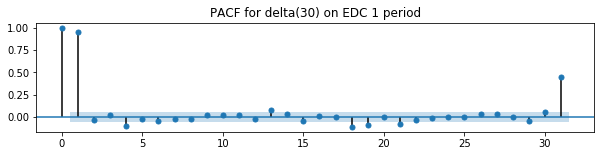

In [19]:
# 4.7. ACF and PACF 
for col in sector_composite_norm.columns:
    show_acf_pacf(sector_composite_norm, col, add_delta=True, delta_step=30)
    
for col in cluster_composite_norm.columns:
    show_acf_pacf(cluster_composite_norm, col, add_delta=True, delta_step=30)

Autocorrelation is very long (more than 30 days), MA component varies from 1 to 4.

#### Hyperparameter tuning

In [20]:
# 5.1. Running for SECTOR
# attention: this cell can take up to 20 min
# note: hyperparameter space here reduced to effective version after some internal iterations
# note: this part commented and can be ignored
# note: do not run this cell in order to keep obtained info from previous runs

#train_index = 866 # correspond to first 80% of timeline

#p_range = [0, 1, 2]
#d_range = [0, 1]
#q_range = [0, 1, 2]
#s = 1

#best_results_sector = dict()

#start_time = time.time()
#idx = 0

#for composite in sector_composite_norm.columns:
#    idx += 1
#    ts = sector_composite_norm[composite]
#    ts = ts.iloc[:train_index]
#    print(f'best params and AIC for {composite}')
#    print(50*'-')
#    best_params = find_optimal_params(ts, p_range, d_range, q_range, s, show_best_params=True, verbose=False)
#    best_results_sector[composite] = best_params
#    print(f'..calculated {idx} of {len(sector_composite_norm.columns)} in {(time.time() - start_time):.0f} sec')
#    print(50*'-')
#    start_time = time.time()

best params and AIC for Basic Materials
--------------------------------------------------
pdq        (0, 0, 0)
pdqs    (1, 0, 0, 1)
aic         -4951.33
Name: 6, dtype: object
..calculated 1 of 12 in 91 sec
--------------------------------------------------
best params and AIC for Communication Services
--------------------------------------------------
pdq        (0, 0, 1)
pdqs    (1, 0, 0, 1)
aic         -5626.77
Name: 24, dtype: object
..calculated 2 of 12 in 94 sec
--------------------------------------------------
best params and AIC for Consumer Cyclical
--------------------------------------------------
pdq        (0, 0, 0)
pdqs    (1, 0, 0, 1)
aic         -5753.23
Name: 6, dtype: object
..calculated 3 of 12 in 94 sec
--------------------------------------------------
best params and AIC for Consumer Defensive
--------------------------------------------------
pdq        (0, 0, 1)
pdqs    (2, 0, 0, 1)
aic         -5939.17
Name: 30, dtype: object
..calculated 4 of 12 in 85 sec
-

In [21]:
# 5.2. Running for CLUSTERS
# attention: this cell can take up to 25 min
# note: hyperparameter space here reduced to effective version after some internal iterations
# note: this part commented and can be ignored
# note: do not run this cell in order to keep obtained info from previous runs

#best_results_cluster = dict()

#p_range = [0, 1, 2]
#d_range = [0, 1]
#q_range = [0, 1, 2]
#s = 1

#start_time = time.time()
#idx = 0

#for composite in cluster_composite_norm.columns:
#    idx += 1
#    ts = cluster_composite_norm[composite]
#    ts = ts.iloc[:train_index]
#    print(f'best params and AIC for {composite}')
#    print(50*'-')
#    best_params = find_optimal_params(ts, p_range, d_range, q_range, s, show_best_params=True, verbose=False)
#    best_results_cluster[composite] = best_params
#    print(f'..calculated {idx} of {len(cluster_composite_norm.columns)} in {(time.time() - start_time):.0f} sec')
#    print(50*'-')
#    start_time = time.time()

best params and AIC for MDY
--------------------------------------------------
pdq        (0, 0, 0)
pdqs    (1, 0, 0, 1)
aic         -5373.69
Name: 6, dtype: object
..calculated 1 of 14 in 95 sec
--------------------------------------------------
best params and AIC for VBR
--------------------------------------------------
pdq        (0, 0, 0)
pdqs    (1, 0, 0, 1)
aic         -5371.38
Name: 6, dtype: object
..calculated 2 of 14 in 88 sec
--------------------------------------------------
best params and AIC for VOE
--------------------------------------------------
pdq        (0, 0, 0)
pdqs    (1, 0, 0, 1)
aic         -5610.15
Name: 6, dtype: object
..calculated 3 of 14 in 91 sec
--------------------------------------------------
best params and AIC for FEX
--------------------------------------------------
pdq        (0, 0, 0)
pdqs    (1, 0, 0, 1)
aic         -5491.31
Name: 6, dtype: object
..calculated 4 of 14 in 97 sec
--------------------------------------------------
best params 

randomly chosen time serie is Consumer Defensive composite
r2 for forecasted 216 days: 92.69% with dynamic = False
r2 for forecasted 216 days: -223.43% with dynamic = True


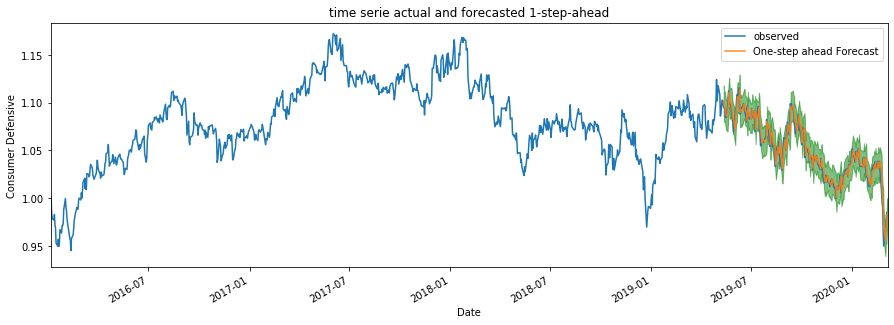

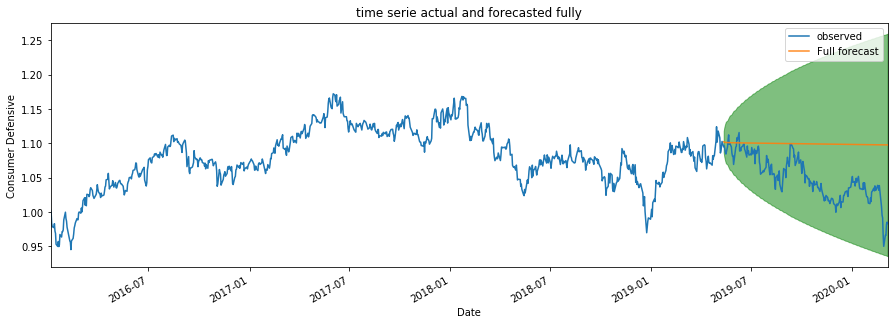

In [22]:
# 5.3. Testing results on a single example. Sector composites. 1-step-ahead and full forecast versions
# Testing process is realized on last 20% of timeline
# note: this part commented and can be ignored
# note: do not run this cell in order to keep obtained info from previous runs

#compos = np.random.choice(sector_composite_norm.columns)

#print(f'randomly chosen time serie is {compos} composite')

#order = best_results_sector[compos][0]
#seasonal_order = best_results_sector[compos][1]
#ts = sector_composite_norm[compos]

#model_base = run_arima_model(ts, order=order, seasonal_order=seasonal_order, show_summary=True, 
#                             plot_forecast=True, show_r2=True, dynamic=False)

#model_base = run_arima_model(ts, order=order, seasonal_order=seasonal_order, show_summary=True, 
#                             plot_forecast=True, show_r2=True, dynamic=True)

randomly chosen time serie is NBTB cluster center
r2 for forecasted 216 days: 93.49% with dynamic = False
r2 for forecasted 216 days: -6.53% with dynamic = True


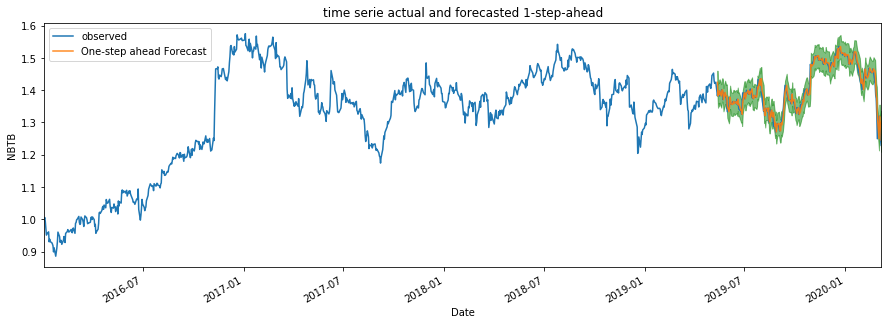

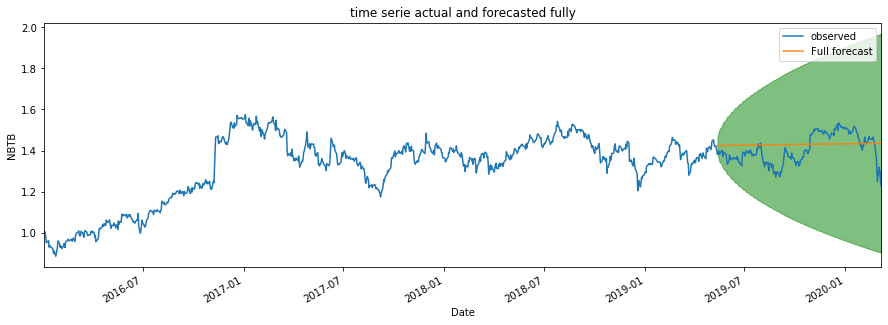

In [23]:
# 5.4. Testing results on a single example. Cluster composites. 1-step-ahead and full forecast versions
# note: this part commented and can be ignored
# note: do not run this cell in order to keep obtained info from previous runs

#compos = np.random.randint(len(cluster_composite.columns))
#compos = cluster_composite.iloc[:, compos]
#print(f'randomly chosen time serie is {compos.name} cluster center')

#order = best_results_cluster[compos.name][0]
#seasonal_order = best_results_cluster[compos.name][1]
#ts = cluster_composite_norm[compos.name]

#model_base = run_arima_model(ts, order=order, seasonal_order=seasonal_order, show_summary=True, 
#                             plot_forecast=True, show_r2=True, dynamic=False)

#model_base = run_arima_model(ts, order=order, seasonal_order=seasonal_order, show_summary=True, 
#                             plot_forecast=True, show_r2=True, dynamic=True)

As shown above, there are good abilities for the models to predict 1-step forecasts (R2 - more than 0.9). However, forecasting to long-term period is impossible to ARIMA models which create linear forecasts.

In [24]:
# 5.5. Saving params

#with open('datasets_4_modelling/order_sector.pkl', 'wb') as f:
#    pickle.dump(best_results_sector, f)

#with open('datasets_4_modelling/order_cluster.pkl', 'wb') as f:
#    pickle.dump(best_results_cluster, f)

#### Collecting all models and validation results

In [25]:
# 6.1. CHECKPOINT. Loading optimised params

with open('datasets_4_modelling/order_sector.pkl', 'rb') as f:
    best_results_sector = pickle.load(f)

with open('datasets_4_modelling/order_cluster.pkl', 'rb') as f:
    best_results_cluster = pickle.load(f)

In [26]:
# 6.2. Collect all models to dict
sector_models = dict()

for sector in sector_composite_norm:
    order = best_results_sector[sector][0]
    seasonal_order = best_results_sector[sector][1]
    model = run_arima_model(sector_composite_norm[sector], order=order, 
                                            seasonal_order=seasonal_order, show_summary=False, 
                                            plot_forecast=False, show_r2=False, dynamic=False)
    sector_models[sector] = model
    
    
cluster_models = dict()
for cluster in cluster_composite_norm:
    order = best_results_cluster[cluster][0]
    seasonal_order = best_results_cluster[cluster][1]
    model = run_arima_model(cluster_composite_norm[cluster], order=order, 
                                            seasonal_order=seasonal_order, show_summary=False, 
                                            plot_forecast=False, show_r2=False, dynamic=False)
    cluster_models[cluster] = model
    

In [27]:
# 6.3. Collecting all results to DataFrame
arima_models_results = pd.DataFrame([])
models, names, r2_1step, r2_216step, params, aic_list, cluster_type = [], [], [], [], [], [], []

for d, df, b, cl_type in zip([sector_models, cluster_models], 
                             [sector_composite_norm, cluster_composite_norm],
                             [best_results_sector, best_results_cluster],
                             ['sector', 'corr_cluster']):
    
    for key, value in d.items():
        names.append(key)
        models.append(value)
        ts = df[key]
        output = value.fit()
        aic_list.append(output.aic)
        r2_1, r2_2 = calculate_r2_on_period(value, 217, ts, ts_name=key)
        r2_1step.append(r2_1)
        r2_216step.append(r2_2)
        param = str(b[key][0])+' '+str(b[key][1])
        params.append(param)
        cluster_type.append(cl_type)

arima_models_results['cluster_type'] = cluster_type
arima_models_results['cluster_name'] = names
arima_models_results['AIC'] = aic_list
arima_models_results['r2_1_step'] = r2_1step
arima_models_results['r2_216_steps'] = r2_216step
arima_models_results['model_params'] = params
arima_models_results['model_instance'] = models

display(arima_models_results.describe())
display(arima_models_results)

AIC  r2_1_step  r2_216_steps
count    26.000000  26.000000     26.000000
mean  -6598.318967   0.929504     -0.402738
std    1002.480376   0.025706      0.891056
min   -8080.249776   0.862521     -3.989144
25%   -7000.946845   0.922644     -0.493958
50%   -6704.624413   0.933372     -0.127150
75%   -6258.645143   0.948332      0.028776
max   -2891.884343   0.969461      0.345952

cluster_type            cluster_name          AIC  r2_1_step  \
0         sector         Basic Materials -6162.394152   0.909932   
1         sector  Communication Services -7024.331548   0.862521   
2         sector       Consumer Cyclical -7105.983294   0.930596   
3         sector      Consumer Defensive -7374.511613   0.896088   
4         sector             Diversified -8080.249776   0.946159   
5         sector                  Energy -6080.342707   0.934349   
6         sector               Financial -7994.787027   0.930320   
7         sector              Healthcare -6813.132663   0.969461   
8         sector             Industrials -6875.033188   0.938927   
9         sector             Real Estate -7714.614065   0.868865   
10        sector              Technology -6583.456940   0.950402   
11        sector               Utilities -6768.574848   0.892012   
12  corr_cluster                     MDY -6547.398114   0.925374   
13  corr_cluster                     VBR -6586.301865   0.929813   
14  corr_cluster                     VOE -6838.386404   0.932395   
15  corr_cluster                     FEX -6640.673978   0.931063   
16  corr_cluster                     FXO -6583.725714   0.915556   
17  corr_cluster                     FXR -6047.779022   0.944134   
18  corr_cluster                     IXG -6616.804926   0.952243   
19  corr_cluster                     AOA -7474.975766   0.949191   
20  corr_cluster                     CWI -6930.792738   0.949551   
21  corr_cluster                     FXZ -6065.294551   0.921734   
22  corr_cluster                     PID -6881.730487   0.951153   
23  corr_cluster                     FXL -5307.014251   0.942065   
24  corr_cluster                    NBTB -5566.119147   0.944150   
25  corr_cluster                     EDC -2891.884343   0.949057   

    r2_216_steps            model_params  \
0      -0.039077  (0, 0, 0) (1, 0, 0, 1)   
1      -3.989144  (0, 0, 1) (1, 0, 0, 1)   
2      -0.528022  (0, 0, 0) (1, 0, 0, 1)   
3      -1.835748  (0, 0, 1) (2, 0, 0, 1)   
4      -0.387873  (0, 0, 0) (1, 0, 0, 1)   
5      -1.616376  (0, 0, 1) (2, 0, 0, 1)   
6      -0.032817  (0, 0, 0) (1, 0, 0, 1)   
7      -0.197901  (1, 0, 0) (1, 0, 1, 1)   
8      -0.058312  (0, 0, 0) (1, 0, 0, 1)   
9      -0.673108  (0, 0, 0) (1, 0, 0, 1)   
10      0.119259  (0, 0, 0) (1, 0, 0, 1)   
11      0.345952  (0, 0, 1) (1, 0, 0, 1)   
12      0.133406  (0, 0, 0) (1, 0, 0, 1)   
13      0.019802  (0, 0, 0) (1, 0, 0, 1)   
14     -0.195989  (0, 0, 0) (1, 0, 0, 1)   
15      0.204392  (0, 0, 0) (1, 0, 0, 1)   
16      0.064655  (0, 0, 0) (1, 0, 0, 1)   
17     -0.044231  (0, 0, 0) (1, 0, 0, 1)   
18     -0.546647  (0, 0, 0) (1, 0, 0, 1)   
19     -0.214532  (0, 0, 0) (1, 0, 0, 1)   
20     -0.503391  (0, 0, 0) (1, 0, 0, 1)   
21      0.031767  (0, 0, 0) (1, 0, 0, 1)   
22     -0.336315  (0, 0, 1) (2, 1, 0, 1)   
23      0.274966  (0, 0, 0) (1, 0, 0, 1)   
24     -0.000239  (0, 0, 0) (1, 0, 0, 1)   
25     -0.465658  (2, 0, 2) (1, 1, 1, 1)   

                                       model_instance  
0   <statsmodels.tsa.statespace.sarimax.SARIMAX ob...  
1   <statsmodels.tsa.statespace.sarimax.SARIMAX ob...  
2   <statsmodels.tsa.statespace.sarimax.SARIMAX ob...  
3   <statsmodels.tsa.statespace.sarimax.SARIMAX ob...  
4   <statsmodels.tsa.statespace.sarimax.SARIMAX ob...  
5   <statsmodels.tsa.statespace.sarimax.SARIMAX ob...  
6   <statsmodels.tsa.statespace.sarimax.SARIMAX ob...  
7   <statsmodels.tsa.statespace.sarimax.SARIMAX ob...  
8   <statsmodels.tsa.statespace.sarimax.SARIMAX ob...  
9   <statsmodels.tsa.statespace.sarimax.SARIMAX ob...  
10  <statsmodels.tsa.statespace.sarimax.SARIMAX ob...  
11  <statsmodels.tsa.statespace.sarimax.SARIMAX ob...  
12  <statsmodels.tsa.statespace.sarimax.SARIMAX ob...  
13  <statsmodels.tsa.statespace.sarimax.SARIMAX ob...  
14  <statsmodels.tsa.statespace.sarimax.SARIMAX ob...  
15  <statsmodels.tsa.statespace.sarimax.SARIMAX ob...  
16  <statsmodels.tsa.state

- r2 score varies from 0.86 to 0.97 (median = 0.93) for 1-step ahead forecast calculated for 216 days
- full-cycle forecast for the whole test timeline (216 days) doesn't provide good quality: for all cases r2_score is negative

Let's compare KDE plots for r2 and AIC for both type of clustering

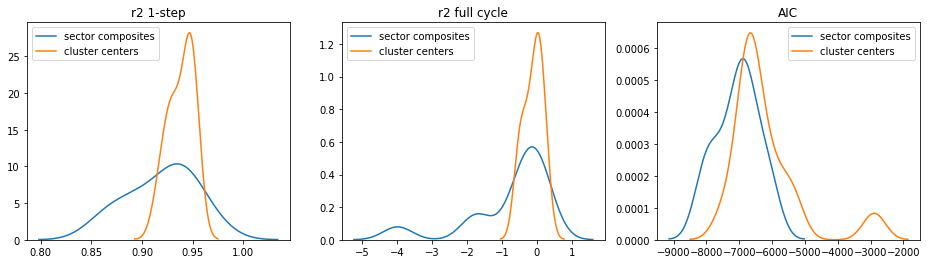

In [28]:
# 6.4. KDE for clustering sets

df_results_sectors = arima_models_results.loc[arima_models_results.cluster_type=='sector']
df_results_clusters = arima_models_results.loc[arima_models_results.cluster_type=='corr_cluster']

fig, ax = plt.subplots(1,3, figsize=(16,4))
ax[0].set_title('r2 1-step')
ax[1].set_title('r2 full cycle')
ax[2].set_title('AIC')

sns.kdeplot(df_results_sectors['r2_1_step'], ax=ax[0], label='sector composites')
sns.kdeplot(df_results_clusters['r2_1_step'], ax=ax[0], label='cluster centers')
sns.kdeplot(df_results_sectors['r2_216_steps'], ax=ax[1], label='sector composites')
sns.kdeplot(df_results_clusters['r2_216_steps'], ax=ax[1], label='cluster centers')
sns.kdeplot(df_results_sectors.AIC, ax=ax[2], label='sector composites')
sns.kdeplot(df_results_clusters.AIC, ax=ax[2], label='cluster centers')
plt.show()

- in general, metrics for r2 and aic are little bit better for cluster centers
- average variation for corr-clustering is smaller, which means that this type less robust and more stable
- it could be due to the fact, that number of companies in corr-clusters is lower than in sectors

Let's look on all forecasts for 1 step-ahead for test period (216 days)

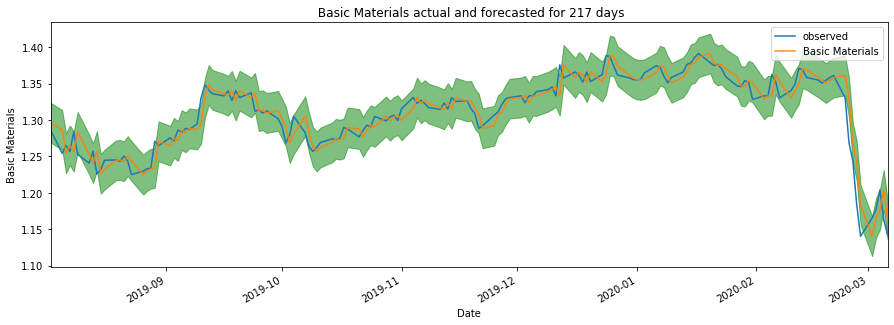

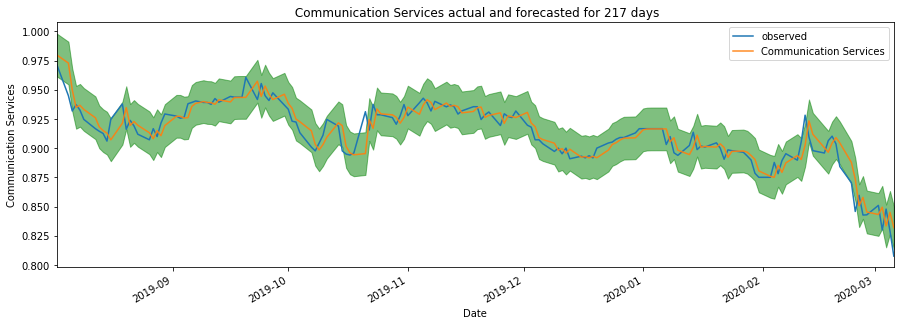

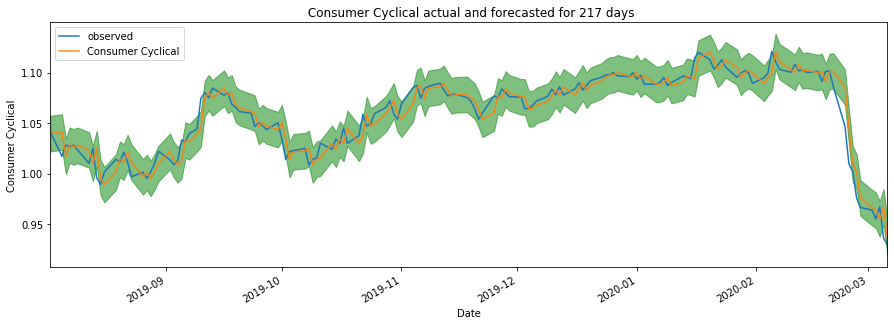

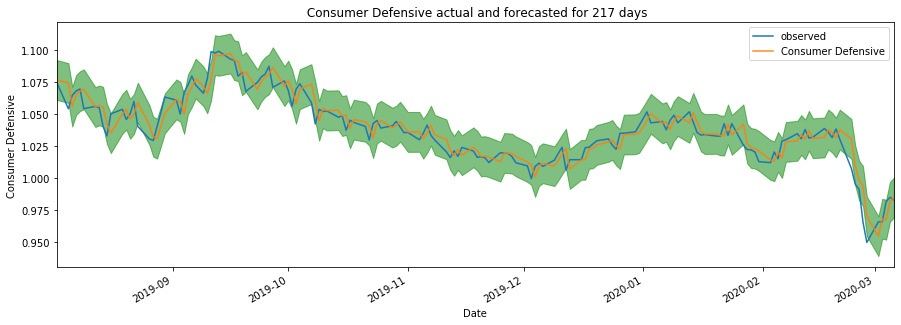

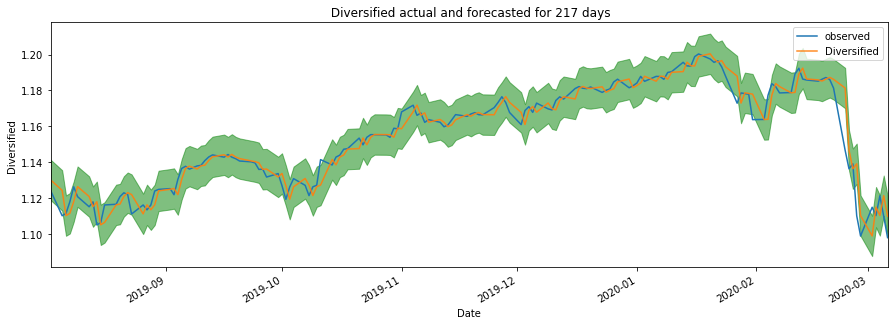

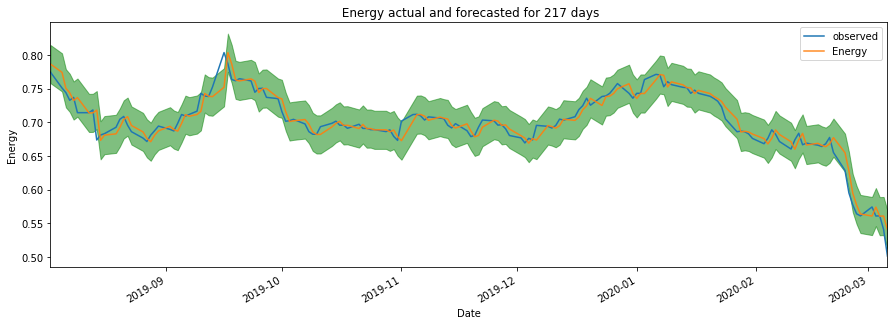

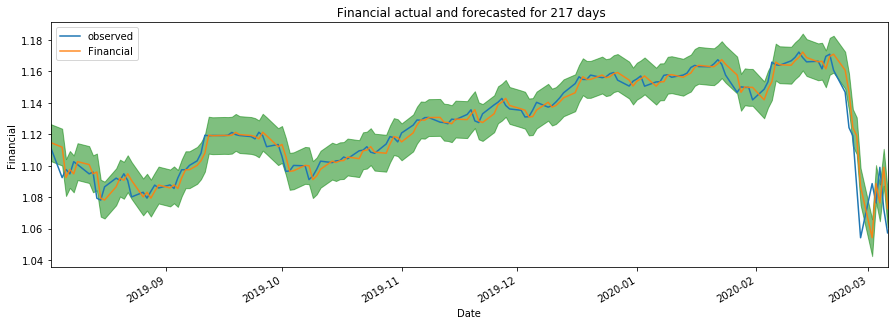

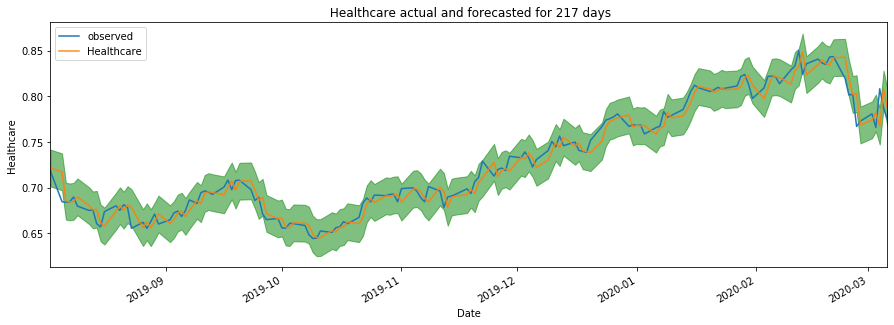

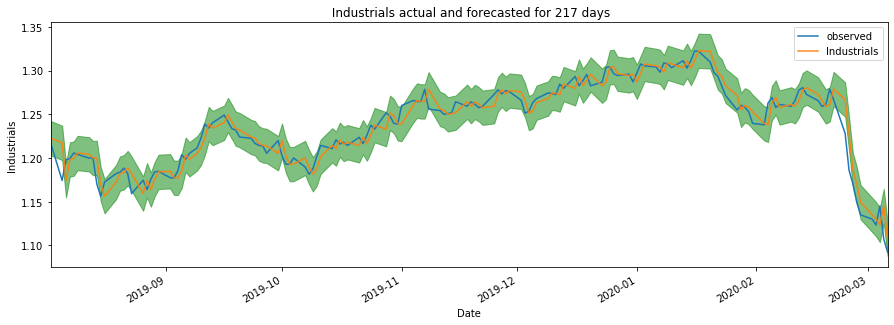

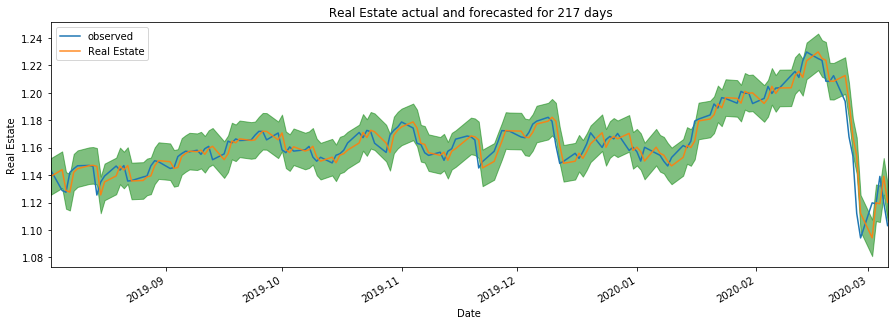

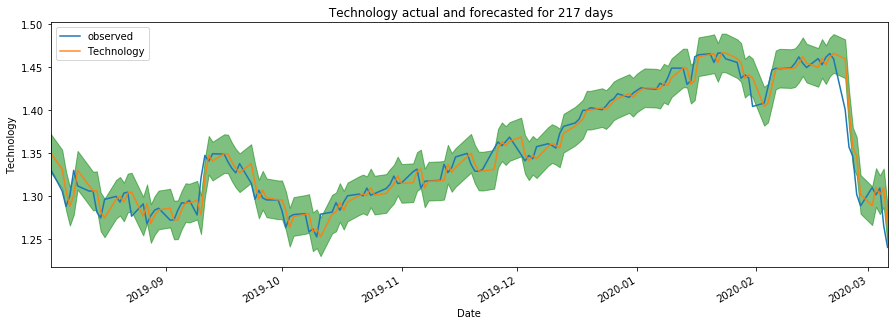

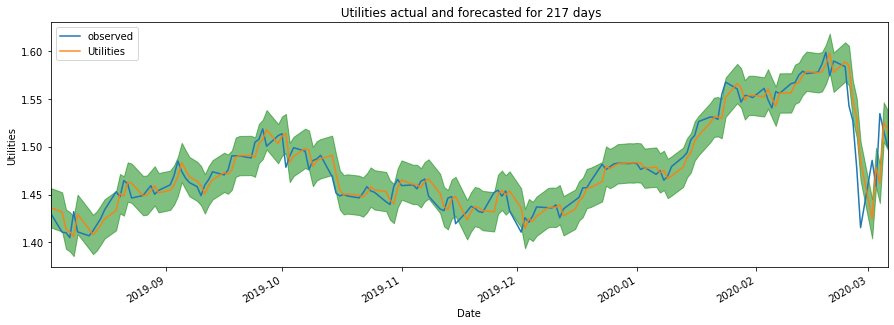

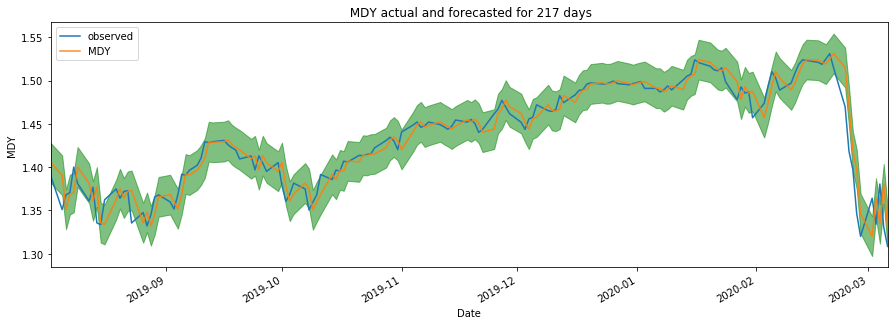

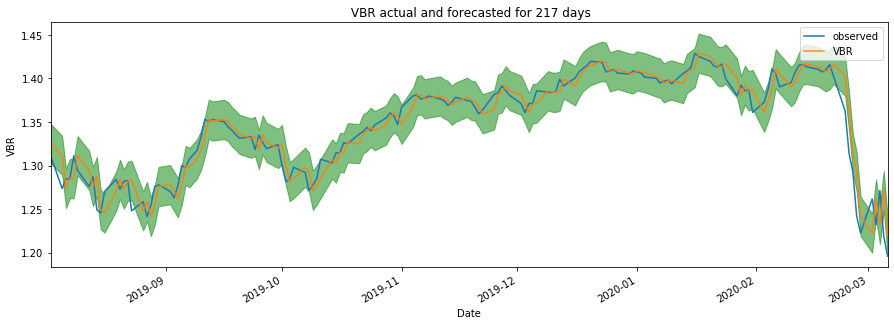

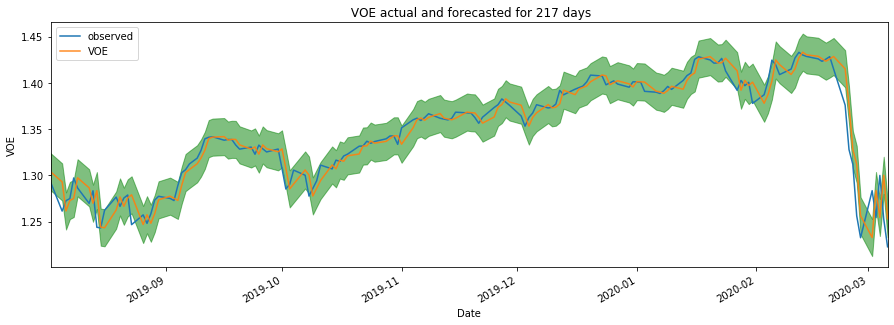

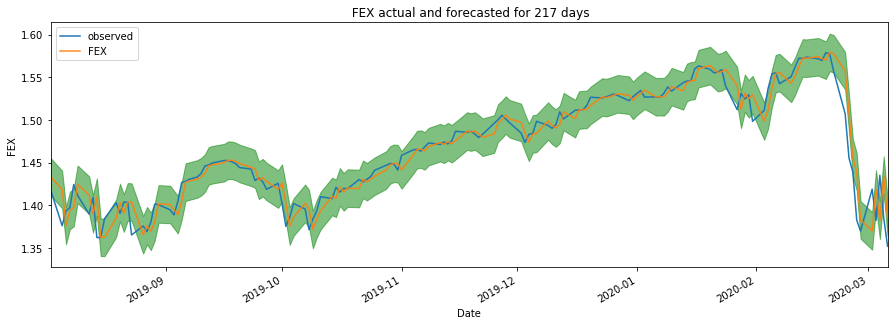

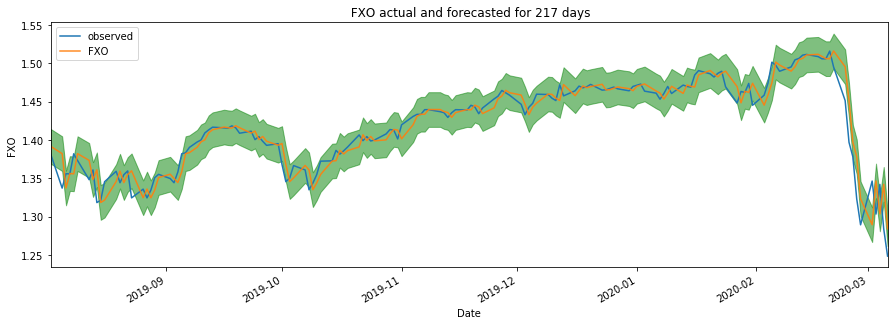

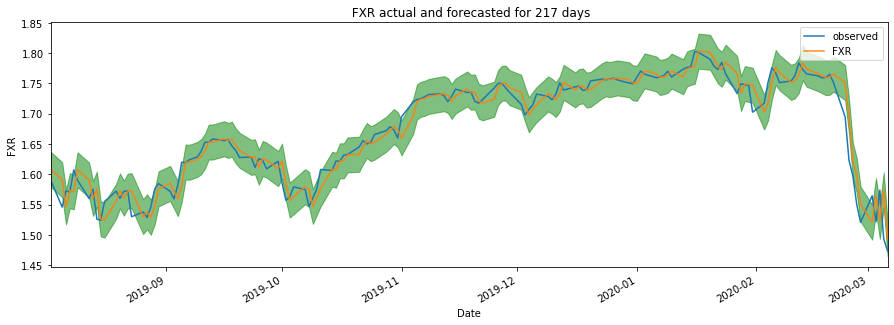

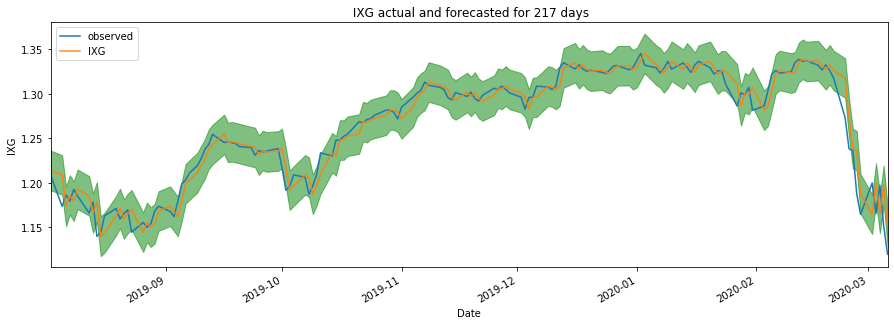

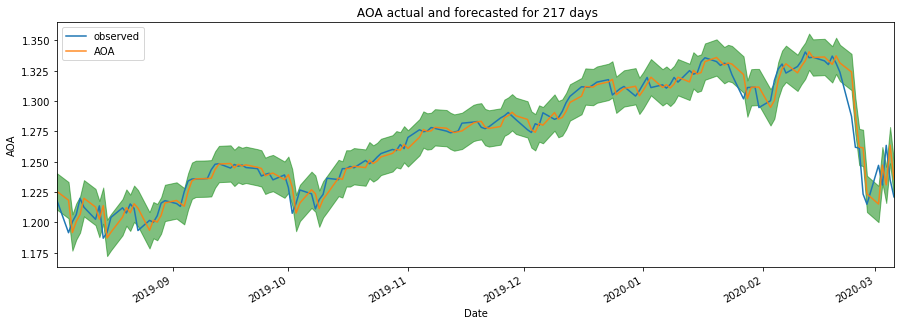

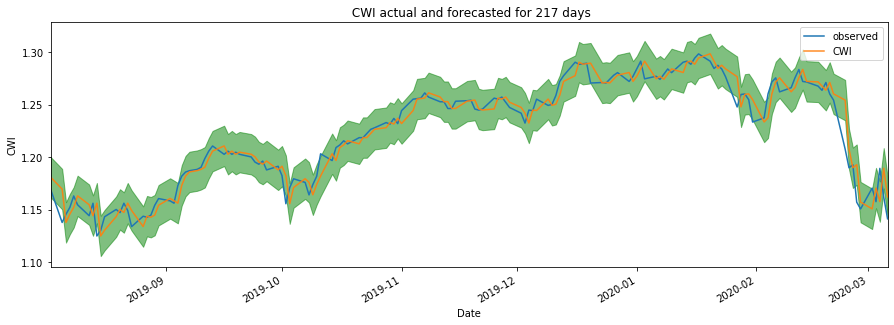

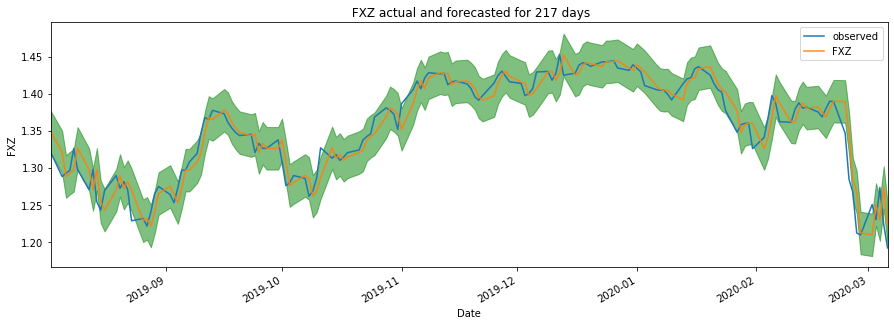

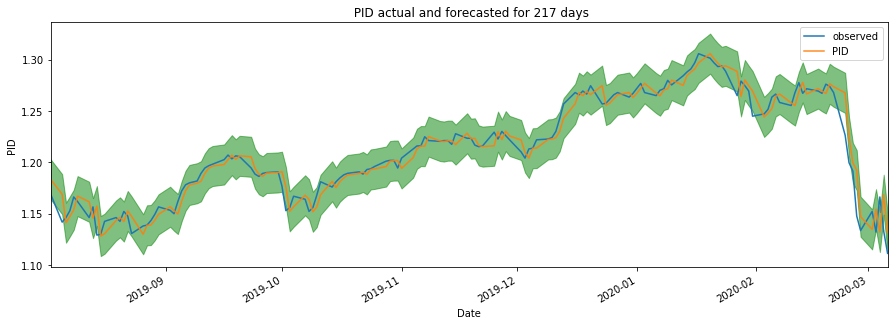

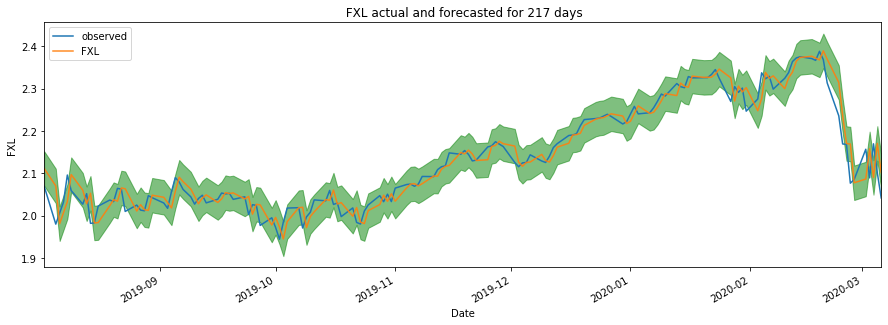

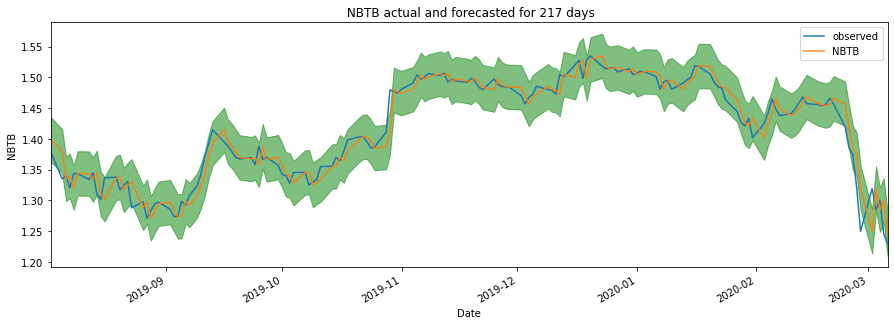

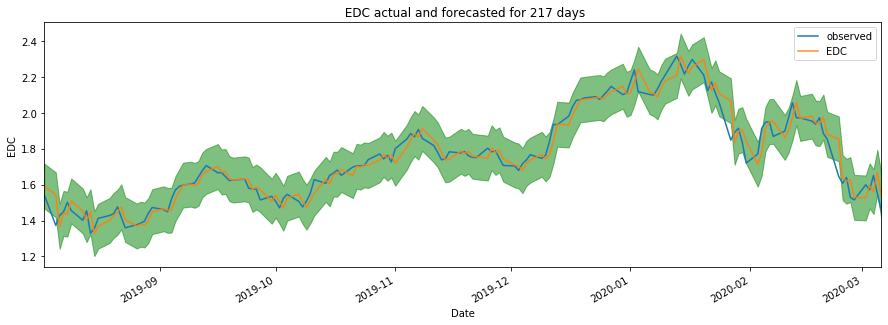

In [29]:
# 6.5. 1-step ahead forecast plots

for d, df in zip([sector_models, cluster_models], 
                             [sector_composite_norm, cluster_composite_norm]):
    
    for key, value in d.items():
        ts = df[key]
        r2_1, r2_2 = calculate_r2_on_period(value, 217, ts, ts_name=key, plot_forecast=True,
                                           dynamic_for_plot=False) 
        
# technically I've put 217 days for that in the function above

It seems, forecasts late to some time lag.  

I did not output the variant of forecast visualization with full-cycle-forecast (`dynamic_for_plot=True`), because the form of forecast is obvious and linear due to the specificity of ARIMA models.

The time series modeling performed in this notebook is some basic benchmark for the next stages - time series forecasting using RNN. The corresponding table of results is exported in the pickle format.

The results show the limitations of ARIMA models that tend to be linear, which does not allow to generate a forecast for several periods ahead. Let's see in the next Steps of Project if the recursive neural network can cope with this.

In [30]:
# exporting result table and data to pickle
    
#with open('datasets_4_modelling/arima_results.pkl', 'wb') as f: 
#    pickle.dump(arima_models_results, f)
    
#with open('datasets_4_modelling/sector_composite_norm.pkl', 'wb') as f: 
#    pickle.dump(sector_composite_norm, f)
    
#with open('datasets_4_modelling/cluster_composite_norm.pkl', 'wb') as f: 
#    pickle.dump(cluster_composite_norm, f)